<a href="https://colab.research.google.com/github/ppiont/cnn-soc-wagga/blob/master/mlp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-optimize

     |████████████████████████████████| 102kB 5.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Thesis/cnn-soc-wagga"

Mounted at /content/drive/
/content/drive/MyDrive/Thesis/cnn-soc-wagga


In [3]:
# Standard lib imports
import os
import pathlib
import random

# Imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize, dump, load
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_objective, plot_convergence, plot_evaluations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import copy
import pdb  # Brug det

In [4]:
# ------------------- TO DO ------------------------------------------------- #

"""
Use Torch Dataset.. you made a class for it dummy
"""

# ------------------- Settings ---------------------------------------------- #


# Set matploblib style
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.dpi'] = 450
plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.format'] = 'svg'

# Reset params if needed
# plt.rcParams.update(mpl.rcParamsDefault)


# ------------------- Organization ------------------------------------------ #


DATA_DIR = pathlib.Path('data/')


def seed_everything(SEED=43):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False


SEED = 43
seed_everything(SEED=SEED)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [5]:
# ------------------- Read and prep data ------------------------------------ #

train_data = np.load(DATA_DIR.joinpath('train.npy'))
test_data = np.load(DATA_DIR.joinpath('test.npy'))

x_train = train_data[:, 1:]
y_train = train_data[:, 0]

input_dims=x_train.shape[-1]

x_test = test_data[:, 1:]
y_test = test_data[:, 0]

# Normalize X
scaler_x = MinMaxScaler()
scaler_x.fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

# Normalize y
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.reshape(-1, 1))
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))
# There is no reason to scale y_test actually
y_test = scaler_y.transform(y_test.reshape(-1, 1))


x_train, y_train = torch.from_numpy(x_train), torch.from_numpy(y_train)
x_test, y_test = torch.from_numpy(x_test), torch.from_numpy(y_test)

x_train, x_test = x_train.to(device), x_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

class Dataset(torch.utils.data.TensorDataset):
    """Characterize a PyTorch Dataset."""

    def __init__(self, features, targets):
        """Initialize with X and y."""
        self.features = features
        self.targets = targets

    def __len__(self):
        """Return total number of samples."""
        return len(self.targets)

    def __getitem__(self, index):
        """Generate one data sample."""
        return self.features[index], self.targets[index]

In [6]:
# ------------------- NN setup ---------------------------------------------- #

class NeuralNet(nn.Module):
    """Neural Network class."""

    def __init__(self, input_dims=input_dims, n_layers=3, n_neurons=64,
                 activation=nn.ELU(), dropout_rate=0.5):
        """Initialize as subclass of nn.Module, inherit its methods."""
        super(NeuralNet, self).__init__()

        self.input_dims = input_dims
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Layer structure
        # First layer
        self.in_layer = nn.Linear(self.input_dims, self.n_neurons)

        # Dense, Dropout, Activation and BN
        self.dense = nn.Linear(self.n_neurons, self.n_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.activation = activation
        self.batchnorm = nn.BatchNorm1d(self.n_neurons)

        # Output layer
        self.out_layer = nn.Linear(self.n_neurons, 1)

    def forward(self, x):
        """Forward pass."""
                
        x = self.batchnorm(self.activation(self.dropout(self.in_layer(x))))

        for i in range(self.n_layers-1):
            x = self.batchnorm(self.activation(self.dropout(self.dense(x))))

        x = self.out_layer(x)

        return x


def train_step(model, features, targets, optimizer, loss_fn):
    """Perform a single training step.

    Calulcates prediction, loss and gradients for a single batch
    and updates optimizer parameters accordingly."""

    # Set gradients to zero
    model.zero_grad()
    # Pass data through model
    output = model(features)
    # Calculate loss
    loss = loss_fn(output, targets)
    # Calculate gradients
    loss.backward()
    # Update parameters
    optimizer.step()

    return loss, output


def train_network(model, train_data, val_data, optimizer, loss_fn,
                  n_epochs=2000, patience=100, print_progress=True):
    """Train a neural network model."""
    # Initalize loss as very high
    best_loss = 1e8

    # Create lists to hold train and val losses
    train_loss = []
    val_loss = []
    # Init epochs_no_improve
    epochs_no_improve = 0
    best_model = copy.deepcopy(model.state_dict())
    
    # Start training (loop over epochs)
    for epoch in range(n_epochs):

        # Initalize epoch train loss
        train_epoch_loss = 0
        # Loop over training batches
        model.train()  # set model to training mode for training
        for bidx, (features, targets) in enumerate(train_data):
            # Calculate loss and predictions
            loss, predictions = train_step(model, features, targets,
                                           optimizer, loss_fn)
            train_epoch_loss += loss
        # Save train epoch loss
        train_loss.append(train_epoch_loss.item())

        # Initialize val epoch loss
        val_epoch_loss = 0
        # Loop over validation batches
        model.eval()  # set model to evaluation mode for validation
        for bidx, (features, targets) in enumerate(val_data):
            output = model(features)
            val_epoch_loss += loss_fn(output, targets)
        # Save val epoch loss
        val_loss.append(val_epoch_loss.item())

        # Early stopping (check if val loss is an improvement on current best)
        if val_epoch_loss < best_loss:
            best_loss = val_epoch_loss.item()
            best_model = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            # Check early stopping condition
            if epochs_no_improve == patience:
                print(f'Stopping after {epoch} epochs due to no improvement.')
                model.load_state_dict(best_model)
                break
        # Print progress at set epoch intervals if desired
        if print_progress:
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1} Train Loss: {train_epoch_loss:.4}, ', end='')
                print(f'Val Loss: {val_epoch_loss:.4}')

    return train_loss, val_loss


def weight_reset(m):
    """Reset all weights in an NN."""
    reset_parameters = getattr(m, "reset_parameters", None)
    if callable(reset_parameters):
        m.reset_parameters()

In [7]:
# ------------------- Cross-validation -------------------------------------- #

def kfold_cv_train(x_train, y_train, model, optimizer,loss_fn=nn.MSELoss(), 
                   n_splits=5, batch_size=312, n_epochs=2000, patience=100,
                   shuffle=True, rng=SEED):
    """Train a NN with K-Fold cross-validation."""
    kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rng)
    best_losses = []

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        # print(f'Starting fold {fold + 1}')
        # Get training and val features
        x_train_fold = x_train[train_index]
        x_val_fold = x_train[val_index]

        # Get training and val targets
        y_train_fold = y_train[train_index]
        y_val_fold = y_train[val_index]

        train = Dataset(x_train_fold, y_train_fold)
        train_loader = DataLoader(train, batch_size=batch_size,
                                  shuffle=shuffle, drop_last=True)
        # Create val dataset and dataloader
        val = Dataset(x_val_fold, y_val_fold)
        val_loader = DataLoader(val, batch_size=batch_size,
                                shuffle=False, drop_last=False)

        # Train
        train_loss, val_loss = train_network(model=model,
                                             train_data=train_loader,
                                             val_data=val_loader,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             n_epochs=n_epochs,
                                             patience=patience,
                                             print_progress=False)
        best_losses.append(min(val_loss))
        model.apply(weight_reset)

    return sum(best_losses)/n_splits, train_loss, val_loss

Gaussian Process:   0%|          | 0/300 [00:00<?, ?it/s]

Iteration No: 1 started. Evaluating function at random point.
Stopping after 213 epochs due to no improvement.
Stopping after 618 epochs due to no improvement.
Stopping after 524 epochs due to no improvement.
Stopping after 403 epochs due to no improvement.


Gaussian Process:   0%|          | 1/300 [01:01<5:04:56, 61.19s/it]

Stopping after 525 epochs due to no improvement.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 61.1790
Function value obtained: 0.0156
Current minimum: 0.0156
Iteration No: 2 started. Evaluating function at random point.
Stopping after 219 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.


Gaussian Process:   1%|          | 2/300 [01:45<4:38:52, 56.15s/it]

Stopping after 273 epochs due to no improvement.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 44.3858
Function value obtained: 0.0161
Current minimum: 0.0156
Iteration No: 3 started. Evaluating function at random point.
Stopping after 245 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.


Gaussian Process:   1%|          | 3/300 [02:36<4:29:35, 54.46s/it]

Stopping after 465 epochs due to no improvement.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 50.5289
Function value obtained: 0.0177
Current minimum: 0.0156
Iteration No: 4 started. Evaluating function at random point.
Stopping after 173 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.


Gaussian Process:   1%|▏         | 4/300 [03:30<4:28:02, 54.33s/it]

Stopping after 682 epochs due to no improvement.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 54.0241
Function value obtained: 0.0173
Current minimum: 0.0156
Iteration No: 5 started. Evaluating function at random point.
Stopping after 401 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.


Gaussian Process:   2%|▏         | 5/300 [04:30<4:35:34, 56.05s/it]

Stopping after 382 epochs due to no improvement.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 60.0550
Function value obtained: 0.0169
Current minimum: 0.0156
Iteration No: 6 started. Evaluating function at random point.
Stopping after 191 epochs due to no improvement.
Stopping after 512 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.


Gaussian Process:   2%|▏         | 6/300 [05:30<4:41:12, 57.39s/it]

Stopping after 411 epochs due to no improvement.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 60.5117
Function value obtained: 0.0168
Current minimum: 0.0156
Iteration No: 7 started. Evaluating function at random point.
Stopping after 234 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 531 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.


Gaussian Process:   2%|▏         | 7/300 [06:17<4:25:26, 54.36s/it]

Stopping after 286 epochs due to no improvement.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 47.2814
Function value obtained: 0.0166
Current minimum: 0.0156
Iteration No: 8 started. Evaluating function at random point.
Stopping after 225 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.


Gaussian Process:   3%|▎         | 8/300 [06:51<3:54:08, 48.11s/it]

Stopping after 325 epochs due to no improvement.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 33.5451
Function value obtained: 0.0171
Current minimum: 0.0156
Iteration No: 9 started. Evaluating function at random point.
Stopping after 193 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.


Gaussian Process:   3%|▎         | 9/300 [07:42<3:57:54, 49.05s/it]

Stopping after 524 epochs due to no improvement.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 51.2488
Function value obtained: 0.0153
Current minimum: 0.0153
Iteration No: 10 started. Evaluating function at random point.
Stopping after 143 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.


Gaussian Process:   3%|▎         | 10/300 [08:41<4:11:07, 51.96s/it]

Stopping after 732 epochs due to no improvement.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 58.7287
Function value obtained: 0.0216
Current minimum: 0.0153
Iteration No: 11 started. Evaluating function at random point.
Stopping after 191 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.


Gaussian Process:   4%|▎         | 11/300 [09:20<3:51:21, 48.03s/it]

Stopping after 295 epochs due to no improvement.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 38.8757
Function value obtained: 0.0158
Current minimum: 0.0153
Iteration No: 12 started. Evaluating function at random point.
Stopping after 301 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 462 epochs due to no improvement.


Gaussian Process:   4%|▍         | 12/300 [10:07<3:49:32, 47.82s/it]

Stopping after 368 epochs due to no improvement.
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 47.3236
Function value obtained: 0.0153
Current minimum: 0.0153
Iteration No: 13 started. Evaluating function at random point.
Stopping after 354 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.
Stopping after 357 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.


Gaussian Process:   4%|▍         | 13/300 [11:06<4:04:06, 51.03s/it]

Stopping after 384 epochs due to no improvement.
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 58.5282
Function value obtained: 0.0180
Current minimum: 0.0153
Iteration No: 14 started. Evaluating function at random point.
Stopping after 334 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.


Gaussian Process:   5%|▍         | 14/300 [11:51<3:55:12, 49.35s/it]

Stopping after 234 epochs due to no improvement.
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 45.4080
Function value obtained: 0.0200
Current minimum: 0.0153
Iteration No: 15 started. Evaluating function at random point.
Stopping after 471 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.


Gaussian Process:   5%|▌         | 15/300 [12:34<3:45:07, 47.39s/it]

Stopping after 189 epochs due to no improvement.
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 42.8392
Function value obtained: 0.0185
Current minimum: 0.0153
Iteration No: 16 started. Evaluating function at random point.
Stopping after 258 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.


Gaussian Process:   5%|▌         | 16/300 [13:12<3:30:19, 44.44s/it]

Stopping after 193 epochs due to no improvement.
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 37.5360
Function value obtained: 0.0183
Current minimum: 0.0153
Iteration No: 17 started. Evaluating function at random point.
Stopping after 276 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 493 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.


Gaussian Process:   6%|▌         | 17/300 [14:14<3:55:27, 49.92s/it]

Stopping after 352 epochs due to no improvement.
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 62.7194
Function value obtained: 0.0167
Current minimum: 0.0153
Iteration No: 18 started. Evaluating function at random point.
Stopping after 458 epochs due to no improvement.
Stopping after 502 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.


Gaussian Process:   6%|▌         | 18/300 [15:21<4:17:49, 54.86s/it]

Stopping after 322 epochs due to no improvement.
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 66.3756
Function value obtained: 0.0157
Current minimum: 0.0153
Iteration No: 19 started. Evaluating function at random point.
Stopping after 165 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.


Gaussian Process:   6%|▋         | 19/300 [15:57<3:51:09, 49.36s/it]

Stopping after 149 epochs due to no improvement.
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 36.5232
Function value obtained: 0.0236
Current minimum: 0.0153
Iteration No: 20 started. Evaluating function at random point.
Stopping after 165 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 577 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.


Gaussian Process:   7%|▋         | 20/300 [16:54<4:01:17, 51.71s/it]

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 57.1867
Function value obtained: 0.0158
Current minimum: 0.0153
Iteration No: 21 started. Searching for the next optimal point.
Stopping after 183 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 216 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.


Gaussian Process:   7%|▋         | 21/300 [17:23<3:27:59, 44.73s/it]

Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 28.4526
Function value obtained: 0.0157
Current minimum: 0.0153
Iteration No: 22 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:   7%|▋         | 22/300 [17:37<2:44:19, 35.47s/it]

Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 13.8494
Function value obtained: 0.2394
Current minimum: 0.0153
Iteration No: 23 started. Searching for the next optimal point.
Stopping after 240 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.


Gaussian Process:   8%|▊         | 23/300 [18:23<2:59:30, 38.88s/it]

Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 46.8517
Function value obtained: 0.1009
Current minimum: 0.0153
Iteration No: 24 started. Searching for the next optimal point.
Stopping after 415 epochs due to no improvement.
Stopping after 990 epochs due to no improvement.
Stopping after 810 epochs due to no improvement.


Gaussian Process:   8%|▊         | 24/300 [21:49<6:48:51, 88.88s/it]

Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 205.5474
Function value obtained: 0.0890
Current minimum: 0.0153
Iteration No: 25 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:   8%|▊         | 25/300 [22:50<6:09:18, 80.58s/it]

Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 61.2026
Function value obtained: 0.0544
Current minimum: 0.0153
Iteration No: 26 started. Searching for the next optimal point.
Stopping after 179 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.


Gaussian Process:   9%|▊         | 26/300 [23:26<5:05:58, 67.00s/it]

Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 35.3269
Function value obtained: 0.0156
Current minimum: 0.0153
Iteration No: 27 started. Searching for the next optimal point.
Stopping after 274 epochs due to no improvement.
Stopping after 544 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.


Gaussian Process:   9%|▉         | 27/300 [24:52<5:31:18, 72.82s/it]

Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 86.3785
Function value obtained: 0.0620
Current minimum: 0.0153
Iteration No: 28 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 506 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.
Stopping after 506 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:   9%|▉         | 28/300 [25:27<4:39:14, 61.60s/it]

Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 35.4182
Function value obtained: 0.1015
Current minimum: 0.0153
Iteration No: 29 started. Searching for the next optimal point.
Stopping after 139 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 130 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.


Gaussian Process:  10%|▉         | 29/300 [25:47<3:42:01, 49.16s/it]

Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 20.1345
Function value obtained: 0.0245
Current minimum: 0.0153
Iteration No: 30 started. Searching for the next optimal point.
Stopping after 603 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 465 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.


Gaussian Process:  10%|█         | 30/300 [26:46<3:54:20, 52.07s/it]

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 58.8810
Function value obtained: 0.0170
Current minimum: 0.0153
Iteration No: 31 started. Searching for the next optimal point.
Stopping after 331 epochs due to no improvement.
Stopping after 471 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.


Gaussian Process:  10%|█         | 31/300 [27:34<3:47:58, 50.85s/it]

Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 47.9916
Function value obtained: 0.0185
Current minimum: 0.0153
Iteration No: 32 started. Searching for the next optimal point.
Stopping after 241 epochs due to no improvement.
Stopping after 476 epochs due to no improvement.
Stopping after 394 epochs due to no improvement.
Stopping after 653 epochs due to no improvement.
Stopping after 537 epochs due to no improvement.


Gaussian Process:  11%|█         | 32/300 [28:34<3:59:02, 53.52s/it]

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 59.7422
Function value obtained: 0.0150
Current minimum: 0.0150
Iteration No: 33 started. Searching for the next optimal point.
Stopping after 275 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.


Gaussian Process:  11%|█         | 33/300 [29:00<3:21:29, 45.28s/it]

Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 26.0531
Function value obtained: 0.2395
Current minimum: 0.0150
Iteration No: 34 started. Searching for the next optimal point.
Stopping after 499 epochs due to no improvement.
Stopping after 262 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.


Gaussian Process:  11%|█▏        | 34/300 [29:42<3:16:09, 44.24s/it]

Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 41.8320
Function value obtained: 0.0305
Current minimum: 0.0150
Iteration No: 35 started. Searching for the next optimal point.
Stopping after 414 epochs due to no improvement.
Stopping after 480 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 35/300 [30:38<3:30:21, 47.63s/it]

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 55.5180
Function value obtained: 0.0169
Current minimum: 0.0150
Iteration No: 36 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 187 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 36/300 [31:08<3:06:33, 42.40s/it]

Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 30.1974
Function value obtained: 0.0243
Current minimum: 0.0150
Iteration No: 37 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.


Gaussian Process:  12%|█▏        | 37/300 [31:31<2:41:04, 36.75s/it]

Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 23.5566
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 38 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.


Gaussian Process:  13%|█▎        | 38/300 [31:56<2:24:29, 33.09s/it]

Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 24.5624
Function value obtained: 109.7030
Current minimum: 0.0150
Iteration No: 39 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 1330 epochs due to no improvement.
Stopping after 1175 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1258 epochs due to no improvement.


Gaussian Process:  13%|█▎        | 39/300 [33:37<3:53:13, 53.61s/it]

Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 101.5035
Function value obtained: 0.0606
Current minimum: 0.0150
Iteration No: 40 started. Searching for the next optimal point.
Stopping after 139 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 469 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  13%|█▎        | 40/300 [34:09<3:24:12, 47.12s/it]

Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 31.9782
Function value obtained: 0.1994
Current minimum: 0.0150
Iteration No: 41 started. Searching for the next optimal point.
Stopping after 224 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 761 epochs due to no improvement.


Gaussian Process:  14%|█▎        | 41/300 [34:44<3:07:19, 43.39s/it]

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 34.6941
Function value obtained: 0.1389
Current minimum: 0.0150
Iteration No: 42 started. Searching for the next optimal point.
Stopping after 276 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.


Gaussian Process:  14%|█▍        | 42/300 [35:31<3:11:12, 44.47s/it]

Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 46.9698
Function value obtained: 0.0687
Current minimum: 0.0150
Iteration No: 43 started. Searching for the next optimal point.
Stopping after 259 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 536 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.


Gaussian Process:  14%|█▍        | 43/300 [36:18<3:13:43, 45.23s/it]

Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 47.0036
Function value obtained: 0.0179
Current minimum: 0.0150
Iteration No: 44 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 360 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.


Gaussian Process:  15%|█▍        | 44/300 [37:14<3:26:27, 48.39s/it]

Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 55.7647
Function value obtained: 0.0196
Current minimum: 0.0150
Iteration No: 45 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.


Gaussian Process:  15%|█▌        | 45/300 [37:45<3:03:17, 43.13s/it]

Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 30.8413
Function value obtained: 0.0176
Current minimum: 0.0150
Iteration No: 46 started. Searching for the next optimal point.
Stopping after 252 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 567 epochs due to no improvement.


Gaussian Process:  15%|█▌        | 46/300 [38:48<3:28:16, 49.20s/it]

Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 63.3625
Function value obtained: 0.0181
Current minimum: 0.0150
Iteration No: 47 started. Searching for the next optimal point.
Stopping after 287 epochs due to no improvement.
Stopping after 428 epochs due to no improvement.
Stopping after 444 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 523 epochs due to no improvement.


Gaussian Process:  16%|█▌        | 47/300 [39:49<3:41:55, 52.63s/it]

Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 60.6357
Function value obtained: 0.0155
Current minimum: 0.0150
Iteration No: 48 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.


Gaussian Process:  16%|█▌        | 48/300 [40:06<2:56:09, 41.94s/it]

Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 17.0140
Function value obtained: 0.2205
Current minimum: 0.0150
Iteration No: 49 started. Searching for the next optimal point.
Stopping after 250 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.


Gaussian Process:  16%|█▋        | 49/300 [40:43<2:49:52, 40.61s/it]

Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 37.4867
Function value obtained: 0.0187
Current minimum: 0.0150
Iteration No: 50 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 177 epochs due to no improvement.
Stopping after 165 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.


Gaussian Process:  17%|█▋        | 50/300 [41:07<2:28:50, 35.72s/it]

Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 24.3242
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 51 started. Searching for the next optimal point.
Stopping after 236 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.


Gaussian Process:  17%|█▋        | 51/300 [41:59<2:48:35, 40.62s/it]

Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 52.0590
Function value obtained: 0.0168
Current minimum: 0.0150
Iteration No: 52 started. Searching for the next optimal point.
Stopping after 323 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.


Gaussian Process:  17%|█▋        | 52/300 [42:45<2:53:55, 42.08s/it]

Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 45.4757
Function value obtained: 0.0187
Current minimum: 0.0150
Iteration No: 53 started. Searching for the next optimal point.
Stopping after 276 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 357 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 53/300 [43:29<2:56:10, 42.79s/it]

Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 44.4626
Function value obtained: 0.0196
Current minimum: 0.0150
Iteration No: 54 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 54/300 [43:49<2:26:23, 35.70s/it]

Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 19.1583
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 55 started. Searching for the next optimal point.
Stopping after 160 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 198 epochs due to no improvement.
Stopping after 159 epochs due to no improvement.


Gaussian Process:  18%|█▊        | 55/300 [44:18<2:17:35, 33.69s/it]

Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 29.0047
Function value obtained: 0.0278
Current minimum: 0.0150
Iteration No: 56 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  19%|█▊        | 56/300 [44:45<2:09:48, 31.92s/it]

Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 27.7854
Function value obtained: 0.1599
Current minimum: 0.0150
Iteration No: 57 started. Searching for the next optimal point.
Stopping after 119 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 357 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.


Gaussian Process:  19%|█▉        | 57/300 [45:21<2:13:35, 32.99s/it]

Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 35.4713
Function value obtained: 0.0161
Current minimum: 0.0150
Iteration No: 58 started. Searching for the next optimal point.
Stopping after 195 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.


Gaussian Process:  19%|█▉        | 58/300 [45:57<2:17:17, 34.04s/it]

Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 36.4912
Function value obtained: 0.0206
Current minimum: 0.0150
Iteration No: 59 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.
Stopping after 306 epochs due to no improvement.


Gaussian Process:  20%|█▉        | 59/300 [46:28<2:12:47, 33.06s/it]

Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 30.7758
Function value obtained: 0.0232
Current minimum: 0.0150
Iteration No: 60 started. Searching for the next optimal point.
Stopping after 241 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.
Stopping after 160 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 324 epochs due to no improvement.


Gaussian Process:  20%|██        | 60/300 [47:09<2:21:25, 35.36s/it]

Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 40.7215
Function value obtained: 0.0193
Current minimum: 0.0150
Iteration No: 61 started. Searching for the next optimal point.
Stopping after 277 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 393 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 470 epochs due to no improvement.


Gaussian Process:  20%|██        | 61/300 [47:54<2:32:15, 38.23s/it]

Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 44.9166
Function value obtained: 0.0227
Current minimum: 0.0150
Iteration No: 62 started. Searching for the next optimal point.
Stopping after 192 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 188 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.


Gaussian Process:  21%|██        | 62/300 [48:24<2:21:36, 35.70s/it]

Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 29.8109
Function value obtained: 0.0185
Current minimum: 0.0150
Iteration No: 63 started. Searching for the next optimal point.
Stopping after 200 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.
Stopping after 367 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.


Gaussian Process:  21%|██        | 63/300 [50:04<3:37:46, 55.13s/it]

Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 100.4655
Function value obtained: 0.2750
Current minimum: 0.0150
Iteration No: 64 started. Searching for the next optimal point.
Stopping after 186 epochs due to no improvement.
Stopping after 199 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.
Stopping after 167 epochs due to no improvement.


Gaussian Process:  21%|██▏       | 64/300 [50:33<3:05:37, 47.19s/it]

Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 28.6631
Function value obtained: 0.0153
Current minimum: 0.0150
Iteration No: 65 started. Searching for the next optimal point.
Stopping after 259 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 65/300 [51:19<3:03:38, 46.89s/it]

Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 46.1787
Function value obtained: 0.0159
Current minimum: 0.0150
Iteration No: 66 started. Searching for the next optimal point.
Stopping after 249 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 66/300 [52:03<2:59:51, 46.12s/it]

Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 44.3243
Function value obtained: 0.0204
Current minimum: 0.0150
Iteration No: 67 started. Searching for the next optimal point.
Stopping after 161 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.


Gaussian Process:  22%|██▏       | 67/300 [52:43<2:52:18, 44.37s/it]

Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 40.2978
Function value obtained: 0.0173
Current minimum: 0.0150
Iteration No: 68 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 141 epochs due to no improvement.


Gaussian Process:  23%|██▎       | 68/300 [53:14<2:35:17, 40.16s/it]

Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 30.3415
Function value obtained: 0.0235
Current minimum: 0.0150
Iteration No: 69 started. Searching for the next optimal point.
Stopping after 141 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.


Gaussian Process:  23%|██▎       | 69/300 [53:47<2:26:24, 38.03s/it]

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 33.0473
Function value obtained: 0.0226
Current minimum: 0.0150
Iteration No: 70 started. Searching for the next optimal point.
Stopping after 122 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.


Gaussian Process:  23%|██▎       | 70/300 [54:22<2:21:54, 37.02s/it]

Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 34.6612
Function value obtained: 0.0235
Current minimum: 0.0150
Iteration No: 71 started. Searching for the next optimal point.
Stopping after 475 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  24%|██▎       | 71/300 [54:57<2:19:46, 36.62s/it]

Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 35.6959
Function value obtained: 0.1421
Current minimum: 0.0150
Iteration No: 72 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 713 epochs due to no improvement.


Gaussian Process:  24%|██▍       | 72/300 [55:37<2:23:07, 37.67s/it]

Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 40.1006
Function value obtained: 0.0391
Current minimum: 0.0150
Iteration No: 73 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1221 epochs due to no improvement.
Stopping after 1566 epochs due to no improvement.


Gaussian Process:  24%|██▍       | 73/300 [56:59<3:12:10, 50.80s/it]

Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 81.4381
Function value obtained: 0.0759
Current minimum: 0.0150
Iteration No: 74 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.


Gaussian Process:  25%|██▍       | 74/300 [57:42<3:03:06, 48.61s/it]

Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 43.5136
Function value obtained: 0.0154
Current minimum: 0.0150
Iteration No: 75 started. Searching for the next optimal point.
Stopping after 322 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 189 epochs due to no improvement.


Gaussian Process:  25%|██▌       | 75/300 [58:28<2:58:48, 47.68s/it]

Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 45.5153
Function value obtained: 0.5516
Current minimum: 0.0150
Iteration No: 76 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 1319 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 1389 epochs due to no improvement.


Gaussian Process:  25%|██▌       | 76/300 [59:48<3:34:38, 57.49s/it]

Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 80.3845
Function value obtained: 0.0617
Current minimum: 0.0150
Iteration No: 77 started. Searching for the next optimal point.
Stopping after 264 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 145 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.


Gaussian Process:  26%|██▌       | 77/300 [1:00:17<3:02:04, 48.99s/it]

Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 29.1397
Function value obtained: 0.0243
Current minimum: 0.0150
Iteration No: 78 started. Searching for the next optimal point.
Stopping after 112 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 308 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.


Gaussian Process:  26%|██▌       | 78/300 [1:00:45<2:37:09, 42.47s/it]

Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 27.2725
Function value obtained: 0.0237
Current minimum: 0.0150
Iteration No: 79 started. Searching for the next optimal point.
Stopping after 224 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 186 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.


Gaussian Process:  26%|██▋       | 79/300 [1:01:23<2:32:02, 41.28s/it]

Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 38.4900
Function value obtained: 0.0154
Current minimum: 0.0150
Iteration No: 80 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 251 epochs due to no improvement.


Gaussian Process:  27%|██▋       | 80/300 [1:01:49<2:14:53, 36.79s/it]

Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 26.3185
Function value obtained: 0.0243
Current minimum: 0.0150
Iteration No: 81 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 545 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.


Gaussian Process:  27%|██▋       | 81/300 [1:02:21<2:08:39, 35.25s/it]

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 31.6440
Function value obtained: 0.0236
Current minimum: 0.0150
Iteration No: 82 started. Searching for the next optimal point.
Stopping after 106 epochs due to no improvement.
Stopping after 344 epochs due to no improvement.
Stopping after 549 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.


Gaussian Process:  27%|██▋       | 82/300 [1:03:06<2:19:02, 38.27s/it]

Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 45.3113
Function value obtained: 0.0227
Current minimum: 0.0150
Iteration No: 83 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 83/300 [1:03:31<2:03:32, 34.16s/it]

Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 24.5750
Function value obtained: 0.0247
Current minimum: 0.0150
Iteration No: 84 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 1099 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 1104 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 84/300 [1:04:53<2:55:04, 48.63s/it]

Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 82.4040
Function value obtained: 0.2788
Current minimum: 0.0150
Iteration No: 85 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.


Gaussian Process:  28%|██▊       | 85/300 [1:05:08<2:18:05, 38.54s/it]

Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 14.9762
Function value obtained: 0.1193
Current minimum: 0.0150
Iteration No: 86 started. Searching for the next optimal point.
Stopping after 321 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 492 epochs due to no improvement.


Gaussian Process:  29%|██▊       | 86/300 [1:06:06<2:37:29, 44.16s/it]

Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 57.2772
Function value obtained: 0.0201
Current minimum: 0.0150
Iteration No: 87 started. Searching for the next optimal point.
Stopping after 106 epochs due to no improvement.
Stopping after 148 epochs due to no improvement.
Stopping after 303 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.


Gaussian Process:  29%|██▉       | 87/300 [1:06:42<2:28:02, 41.70s/it]

Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 35.9673
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 88 started. Searching for the next optimal point.
Stopping after 116 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.


Gaussian Process:  29%|██▉       | 88/300 [1:07:05<2:07:50, 36.18s/it]

Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 23.2984
Function value obtained: 0.0244
Current minimum: 0.0150
Iteration No: 89 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  30%|██▉       | 89/300 [1:07:24<1:49:01, 31.00s/it]

Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 18.9128
Function value obtained: 0.0875
Current minimum: 0.0150
Iteration No: 90 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.


Gaussian Process:  30%|███       | 90/300 [1:07:44<1:37:19, 27.81s/it]

Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 20.3595
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 91 started. Searching for the next optimal point.
Stopping after 113 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 360 epochs due to no improvement.


Gaussian Process:  30%|███       | 91/300 [1:08:08<1:33:12, 26.76s/it]

Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 24.3147
Function value obtained: 0.0235
Current minimum: 0.0150
Iteration No: 92 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1253 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  31%|███       | 92/300 [1:09:10<2:09:10, 37.26s/it]

Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 61.7694
Function value obtained: 0.0487
Current minimum: 0.0150
Iteration No: 93 started. Searching for the next optimal point.
Stopping after 216 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 171 epochs due to no improvement.


Gaussian Process:  31%|███       | 93/300 [1:09:45<2:05:47, 36.46s/it]

Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 34.5888
Function value obtained: 0.0189
Current minimum: 0.0150
Iteration No: 94 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1220 epochs due to no improvement.
Stopping after 1182 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.


Gaussian Process:  31%|███▏      | 94/300 [1:10:59<2:43:37, 47.66s/it]

Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 73.7791
Function value obtained: 0.0671
Current minimum: 0.0150
Iteration No: 95 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 1494 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 95/300 [1:12:03<2:59:45, 52.61s/it]

Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 64.1702
Function value obtained: 0.1414
Current minimum: 0.0150
Iteration No: 96 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 135 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 96/300 [1:12:28<2:31:23, 44.53s/it]

Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 25.6591
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 97 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.


Gaussian Process:  32%|███▏      | 97/300 [1:12:44<2:01:11, 35.82s/it]

Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 15.5154
Function value obtained: 0.1307
Current minimum: 0.0150
Iteration No: 98 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.


Gaussian Process:  33%|███▎      | 98/300 [1:13:05<1:46:01, 31.49s/it]

Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 21.3893
Function value obtained: 0.1846
Current minimum: 0.0150
Iteration No: 99 started. Searching for the next optimal point.
Stopping after 435 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  33%|███▎      | 99/300 [1:16:24<4:33:54, 81.76s/it]

Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 199.0568
Function value obtained: 0.0755
Current minimum: 0.0150
Iteration No: 100 started. Searching for the next optimal point.
Stopping after 995 epochs due to no improvement.


Gaussian Process:  33%|███▎      | 100/300 [1:21:27<8:13:49, 148.15s/it]

Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 303.0422
Function value obtained: 0.0431
Current minimum: 0.0150
Iteration No: 101 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.


Gaussian Process:  34%|███▎      | 101/300 [1:21:59<6:15:16, 113.15s/it]

Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 31.4820
Function value obtained: 0.0234
Current minimum: 0.0150
Iteration No: 102 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 241 epochs due to no improvement.
Stopping after 319 epochs due to no improvement.


Gaussian Process:  34%|███▍      | 102/300 [1:22:29<4:51:36, 88.37s/it] 

Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 30.5490
Function value obtained: 0.0240
Current minimum: 0.0150
Iteration No: 103 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 292 epochs due to no improvement.
Stopping after 197 epochs due to no improvement.


Gaussian Process:  34%|███▍      | 103/300 [1:23:00<3:53:30, 71.12s/it]

Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 30.8724
Function value obtained: 0.0234
Current minimum: 0.0150
Iteration No: 104 started. Searching for the next optimal point.
Stopping after 140 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.


Gaussian Process:  35%|███▍      | 104/300 [1:23:26<3:07:51, 57.51s/it]

Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 25.7518
Function value obtained: 0.0237
Current minimum: 0.0150
Iteration No: 105 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.


Gaussian Process:  35%|███▌      | 105/300 [1:23:45<2:29:18, 45.94s/it]

Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 18.9399
Function value obtained: 0.0241
Current minimum: 0.0150
Iteration No: 106 started. Searching for the next optimal point.
Stopping after 281 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.


Gaussian Process:  35%|███▌      | 106/300 [1:24:28<2:25:51, 45.11s/it]

Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 43.1863
Function value obtained: 0.0180
Current minimum: 0.0150
Iteration No: 107 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 164 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 146 epochs due to no improvement.


Gaussian Process:  36%|███▌      | 107/300 [1:24:50<2:02:23, 38.05s/it]

Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 21.5676
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 108 started. Searching for the next optimal point.
Stopping after 304 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.


Gaussian Process:  36%|███▌      | 108/300 [1:25:48<2:21:18, 44.16s/it]

Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 58.4161
Function value obtained: 0.0175
Current minimum: 0.0150
Iteration No: 109 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 152 epochs due to no improvement.
Stopping after 233 epochs due to no improvement.
Stopping after 161 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.


Gaussian Process:  36%|███▋      | 109/300 [1:26:17<2:06:11, 39.64s/it]

Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 29.1008
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 110 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.


Gaussian Process:  37%|███▋      | 110/300 [1:26:51<1:59:45, 37.82s/it]

Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 33.5718
Function value obtained: 0.0232
Current minimum: 0.0150
Iteration No: 111 started. Searching for the next optimal point.
Stopping after 170 epochs due to no improvement.
Stopping after 430 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.
Stopping after 364 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.


Gaussian Process:  37%|███▋      | 111/300 [1:27:40<2:09:38, 41.16s/it]

Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 48.9421
Function value obtained: 0.0160
Current minimum: 0.0150
Iteration No: 112 started. Searching for the next optimal point.
Stopping after 280 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 209 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.


Gaussian Process:  37%|███▋      | 112/300 [1:28:16<2:04:36, 39.77s/it]

Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 36.5331
Function value obtained: 0.0186
Current minimum: 0.0150
Iteration No: 113 started. Searching for the next optimal point.
Stopping after 307 epochs due to no improvement.
Stopping after 168 epochs due to no improvement.
Stopping after 377 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 113/300 [1:29:04<2:11:45, 42.28s/it]

Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 48.1233
Function value obtained: 0.0180
Current minimum: 0.0150
Iteration No: 114 started. Searching for the next optimal point.
Stopping after 317 epochs due to no improvement.
Stopping after 554 epochs due to no improvement.
Stopping after 568 epochs due to no improvement.
Stopping after 179 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 114/300 [1:30:02<2:25:02, 46.79s/it]

Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 57.3085
Function value obtained: 0.0202
Current minimum: 0.0150
Iteration No: 115 started. Searching for the next optimal point.
Stopping after 313 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.
Stopping after 226 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.


Gaussian Process:  38%|███▊      | 115/300 [1:30:45<2:20:31, 45.57s/it]

Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 42.7429
Function value obtained: 0.0173
Current minimum: 0.0150
Iteration No: 116 started. Searching for the next optimal point.
Stopping after 271 epochs due to no improvement.
Stopping after 679 epochs due to no improvement.
Stopping after 394 epochs due to no improvement.
Stopping after 465 epochs due to no improvement.
Stopping after 730 epochs due to no improvement.


Gaussian Process:  39%|███▊      | 116/300 [1:32:05<2:51:39, 55.98s/it]

Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 80.2513
Function value obtained: 0.0152
Current minimum: 0.0150
Iteration No: 117 started. Searching for the next optimal point.
Stopping after 258 epochs due to no improvement.
Stopping after 521 epochs due to no improvement.
Stopping after 386 epochs due to no improvement.
Stopping after 677 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.


Gaussian Process:  39%|███▉      | 117/300 [1:33:09<2:57:53, 58.32s/it]

Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 63.7992
Function value obtained: 0.0167
Current minimum: 0.0150
Iteration No: 118 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 555 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.


Gaussian Process:  39%|███▉      | 118/300 [1:34:03<2:53:08, 57.08s/it]

Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 54.1747
Function value obtained: 0.0157
Current minimum: 0.0150
Iteration No: 119 started. Searching for the next optimal point.
Stopping after 543 epochs due to no improvement.
Stopping after 272 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 602 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.


Gaussian Process:  40%|███▉      | 119/300 [1:34:56<2:48:24, 55.83s/it]

Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 52.9111
Function value obtained: 0.0178
Current minimum: 0.0150
Iteration No: 120 started. Searching for the next optimal point.
Stopping after 558 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 615 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 348 epochs due to no improvement.


Gaussian Process:  40%|████      | 120/300 [1:35:58<2:53:27, 57.82s/it]

Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 62.4559
Function value obtained: 0.0195
Current minimum: 0.0150
Iteration No: 121 started. Searching for the next optimal point.
Stopping after 251 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.
Stopping after 482 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.


Gaussian Process:  40%|████      | 121/300 [1:36:57<2:53:35, 58.19s/it]

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 59.0494
Function value obtained: 0.0162
Current minimum: 0.0150
Iteration No: 122 started. Searching for the next optimal point.
Stopping after 353 epochs due to no improvement.
Stopping after 460 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.


Gaussian Process:  41%|████      | 122/300 [1:37:47<2:45:08, 55.67s/it]

Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 49.7856
Function value obtained: 0.0203
Current minimum: 0.0150
Iteration No: 123 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.


Gaussian Process:  41%|████      | 123/300 [1:38:31<2:34:00, 52.21s/it]

Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 44.1305
Function value obtained: 0.0231
Current minimum: 0.0150
Iteration No: 124 started. Searching for the next optimal point.
Stopping after 381 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 427 epochs due to no improvement.
Stopping after 379 epochs due to no improvement.
Stopping after 416 epochs due to no improvement.


Gaussian Process:  41%|████▏     | 124/300 [1:39:31<2:39:35, 54.41s/it]

Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 59.5400
Function value obtained: 0.0173
Current minimum: 0.0150
Iteration No: 125 started. Searching for the next optimal point.
Stopping after 101 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 125/300 [1:39:58<2:14:42, 46.19s/it]

Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 27.0030
Function value obtained: 0.1237
Current minimum: 0.0150
Iteration No: 126 started. Searching for the next optimal point.
Stopping after 402 epochs due to no improvement.
Stopping after 521 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 126/300 [1:41:08<2:34:53, 53.41s/it]

Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 70.2756
Function value obtained: 0.0167
Current minimum: 0.0150
Iteration No: 127 started. Searching for the next optimal point.
Stopping after 245 epochs due to no improvement.
Stopping after 271 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 203 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.


Gaussian Process:  42%|████▏     | 127/300 [1:41:48<2:22:37, 49.47s/it]

Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 40.2576
Function value obtained: 0.0195
Current minimum: 0.0150
Iteration No: 128 started. Searching for the next optimal point.
Stopping after 194 epochs due to no improvement.
Stopping after 310 epochs due to no improvement.
Stopping after 140 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.
Stopping after 488 epochs due to no improvement.


Gaussian Process:  43%|████▎     | 128/300 [1:42:25<2:10:37, 45.57s/it]

Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 36.4692
Function value obtained: 0.0218
Current minimum: 0.0150
Iteration No: 129 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 212 epochs due to no improvement.


Gaussian Process:  43%|████▎     | 129/300 [1:42:59<2:00:36, 42.32s/it]

Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 34.7311
Function value obtained: 0.0185
Current minimum: 0.0150
Iteration No: 130 started. Searching for the next optimal point.
Stopping after 352 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 183 epochs due to no improvement.


Gaussian Process:  43%|████▎     | 130/300 [1:43:53<2:09:24, 45.67s/it]

Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 53.5072
Function value obtained: 0.0166
Current minimum: 0.0150
Iteration No: 131 started. Searching for the next optimal point.
Stopping after 398 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 446 epochs due to no improvement.
Stopping after 396 epochs due to no improvement.
Stopping after 610 epochs due to no improvement.


Gaussian Process:  44%|████▎     | 131/300 [1:45:16<2:39:54, 56.77s/it]

Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 82.6699
Function value obtained: 0.0163
Current minimum: 0.0150
Iteration No: 132 started. Searching for the next optimal point.
Stopping after 177 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 277 epochs due to no improvement.
Stopping after 222 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.


Gaussian Process:  44%|████▍     | 132/300 [1:45:59<2:27:41, 52.75s/it]

Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 43.3569
Function value obtained: 0.0183
Current minimum: 0.0150
Iteration No: 133 started. Searching for the next optimal point.
Stopping after 210 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.
Stopping after 368 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.
Stopping after 433 epochs due to no improvement.


Gaussian Process:  44%|████▍     | 133/300 [1:47:00<2:34:12, 55.40s/it]

Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 61.5948
Function value obtained: 0.0164
Current minimum: 0.0150
Iteration No: 134 started. Searching for the next optimal point.
Stopping after 281 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.
Stopping after 155 epochs due to no improvement.


Gaussian Process:  45%|████▍     | 134/300 [1:47:45<2:24:18, 52.16s/it]

Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 44.5984
Function value obtained: 0.0196
Current minimum: 0.0150
Iteration No: 135 started. Searching for the next optimal point.
Stopping after 393 epochs due to no improvement.
Stopping after 548 epochs due to no improvement.
Stopping after 295 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.
Stopping after 565 epochs due to no improvement.


Gaussian Process:  45%|████▌     | 135/300 [1:49:02<2:44:09, 59.69s/it]

Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 77.2737
Function value obtained: 0.0159
Current minimum: 0.0150
Iteration No: 136 started. Searching for the next optimal point.
Stopping after 132 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.


Gaussian Process:  45%|████▌     | 136/300 [1:49:30<2:17:03, 50.14s/it]

Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 27.8531
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 137 started. Searching for the next optimal point.
Stopping after 449 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 611 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.


Gaussian Process:  46%|████▌     | 137/300 [1:50:29<2:23:21, 52.77s/it]

Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 58.8945
Function value obtained: 0.0508
Current minimum: 0.0150
Iteration No: 138 started. Searching for the next optimal point.
Stopping after 208 epochs due to no improvement.
Stopping after 537 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 502 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.


Gaussian Process:  46%|████▌     | 138/300 [1:51:20<2:21:09, 52.28s/it]

Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 51.1505
Function value obtained: 0.0158
Current minimum: 0.0150
Iteration No: 139 started. Searching for the next optimal point.
Stopping after 1194 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 1015 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 985 epochs due to no improvement.


Gaussian Process:  46%|████▋     | 139/300 [1:52:54<2:53:25, 64.63s/it]

Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 93.4350
Function value obtained: 0.0383
Current minimum: 0.0150
Iteration No: 140 started. Searching for the next optimal point.
Stopping after 247 epochs due to no improvement.
Stopping after 309 epochs due to no improvement.
Stopping after 291 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.


Gaussian Process:  47%|████▋     | 140/300 [1:53:36<2:34:51, 58.07s/it]

Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 42.7652
Function value obtained: 0.0162
Current minimum: 0.0150
Iteration No: 141 started. Searching for the next optimal point.
Stopping after 353 epochs due to no improvement.
Stopping after 427 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 807 epochs due to no improvement.
Stopping after 345 epochs due to no improvement.


Gaussian Process:  47%|████▋     | 141/300 [1:55:00<2:54:21, 65.80s/it]

Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 83.8215
Function value obtained: 0.0157
Current minimum: 0.0150
Iteration No: 142 started. Searching for the next optimal point.
Stopping after 168 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 213 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.


Gaussian Process:  47%|████▋     | 142/300 [1:55:44<2:35:54, 59.20s/it]

Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 43.8197
Function value obtained: 0.0192
Current minimum: 0.0150
Iteration No: 143 started. Searching for the next optimal point.
Stopping after 217 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.
Stopping after 561 epochs due to no improvement.
Stopping after 639 epochs due to no improvement.
Stopping after 607 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 143/300 [1:57:09<2:54:55, 66.85s/it]

Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 84.6904
Function value obtained: 0.0173
Current minimum: 0.0150
Iteration No: 144 started. Searching for the next optimal point.
Stopping after 223 epochs due to no improvement.
Stopping after 359 epochs due to no improvement.
Stopping after 323 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.
Stopping after 481 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 144/300 [1:58:13<2:51:51, 66.10s/it]

Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 64.3600
Function value obtained: 0.0168
Current minimum: 0.0150
Iteration No: 145 started. Searching for the next optimal point.
Stopping after 309 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 133 epochs due to no improvement.
Stopping after 132 epochs due to no improvement.
Stopping after 535 epochs due to no improvement.


Gaussian Process:  48%|████▊     | 145/300 [1:59:05<2:40:02, 61.95s/it]

Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 52.2577
Function value obtained: 0.0180
Current minimum: 0.0150
Iteration No: 146 started. Searching for the next optimal point.
Stopping after 174 epochs due to no improvement.
Stopping after 460 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 479 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.


Gaussian Process:  49%|████▊     | 146/300 [2:00:05<2:36:55, 61.14s/it]

Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 59.2605
Function value obtained: 0.0174
Current minimum: 0.0150
Iteration No: 147 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.


Gaussian Process:  49%|████▉     | 147/300 [2:00:50<2:23:35, 56.31s/it]

Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 45.0255
Function value obtained: 0.0229
Current minimum: 0.0150
Iteration No: 148 started. Searching for the next optimal point.
Stopping after 109 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 304 epochs due to no improvement.
Stopping after 220 epochs due to no improvement.
Stopping after 373 epochs due to no improvement.


Gaussian Process:  49%|████▉     | 148/300 [2:01:35<2:13:56, 52.87s/it]

Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 44.8441
Function value obtained: 0.0232
Current minimum: 0.0150
Iteration No: 149 started. Searching for the next optimal point.
Stopping after 418 epochs due to no improvement.
Stopping after 604 epochs due to no improvement.
Stopping after 153 epochs due to no improvement.
Stopping after 652 epochs due to no improvement.
Stopping after 608 epochs due to no improvement.


Gaussian Process:  50%|████▉     | 149/300 [2:02:54<2:33:18, 60.92s/it]

Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 79.6926
Function value obtained: 0.0163
Current minimum: 0.0150
Iteration No: 150 started. Searching for the next optimal point.
Stopping after 378 epochs due to no improvement.
Stopping after 196 epochs due to no improvement.
Stopping after 457 epochs due to no improvement.
Stopping after 382 epochs due to no improvement.
Stopping after 127 epochs due to no improvement.


Gaussian Process:  50%|█████     | 150/300 [2:03:47<2:25:56, 58.38s/it]

Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 52.4562
Function value obtained: 0.0168
Current minimum: 0.0150
Iteration No: 151 started. Searching for the next optimal point.
Stopping after 759 epochs due to no improvement.
Stopping after 819 epochs due to no improvement.
Stopping after 693 epochs due to no improvement.
Stopping after 700 epochs due to no improvement.
Stopping after 766 epochs due to no improvement.


Gaussian Process:  50%|█████     | 151/300 [2:05:45<3:09:59, 76.51s/it]

Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 118.8064
Function value obtained: 0.0157
Current minimum: 0.0150
Iteration No: 152 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 336 epochs due to no improvement.
Stopping after 442 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.
Stopping after 541 epochs due to no improvement.


Gaussian Process:  51%|█████     | 152/300 [2:06:43<2:54:59, 70.94s/it]

Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 57.9509
Function value obtained: 0.0184
Current minimum: 0.0150
Iteration No: 153 started. Searching for the next optimal point.
Stopping after 122 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 224 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.


Gaussian Process:  51%|█████     | 153/300 [2:07:24<2:31:30, 61.84s/it]

Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 40.6055
Function value obtained: 0.0241
Current minimum: 0.0150
Iteration No: 154 started. Searching for the next optimal point.
Stopping after 127 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.
Stopping after 556 epochs due to no improvement.
Stopping after 265 epochs due to no improvement.


Gaussian Process:  51%|█████▏    | 154/300 [2:08:15<2:22:52, 58.72s/it]

Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 51.4279
Function value obtained: 0.0163
Current minimum: 0.0150
Iteration No: 155 started. Searching for the next optimal point.
Stopping after 254 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 275 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 155/300 [2:09:00<2:11:19, 54.34s/it]

Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 44.1358
Function value obtained: 0.0218
Current minimum: 0.0150
Iteration No: 156 started. Searching for the next optimal point.
Stopping after 228 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.
Stopping after 374 epochs due to no improvement.
Stopping after 122 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 156/300 [2:09:40<2:00:29, 50.20s/it]

Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 40.5459
Function value obtained: 0.0184
Current minimum: 0.0150
Iteration No: 157 started. Searching for the next optimal point.
Stopping after 213 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 553 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.


Gaussian Process:  52%|█████▏    | 157/300 [2:10:33<2:01:45, 51.09s/it]

Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 53.1529
Function value obtained: 0.0152
Current minimum: 0.0150
Iteration No: 158 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 267 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.


Gaussian Process:  53%|█████▎    | 158/300 [2:11:18<1:56:28, 49.21s/it]

Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 44.8343
Function value obtained: 0.0174
Current minimum: 0.0150
Iteration No: 159 started. Searching for the next optimal point.
Stopping after 369 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 219 epochs due to no improvement.


Gaussian Process:  53%|█████▎    | 159/300 [2:11:58<1:49:09, 46.45s/it]

Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 40.0081
Function value obtained: 0.0205
Current minimum: 0.0150
Iteration No: 160 started. Searching for the next optimal point.
Stopping after 146 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 318 epochs due to no improvement.


Gaussian Process:  53%|█████▎    | 160/300 [2:12:28<1:36:42, 41.44s/it]

Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 29.7634
Function value obtained: 0.0183
Current minimum: 0.0150
Iteration No: 161 started. Searching for the next optimal point.
Stopping after 298 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 474 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.


Gaussian Process:  54%|█████▎    | 161/300 [2:13:22<1:44:38, 45.17s/it]

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 53.8477
Function value obtained: 0.0151
Current minimum: 0.0150
Iteration No: 162 started. Searching for the next optimal point.
Stopping after 441 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 407 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.


Gaussian Process:  54%|█████▍    | 162/300 [2:14:23<1:55:14, 50.11s/it]

Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 61.6351
Function value obtained: 0.0158
Current minimum: 0.0150
Iteration No: 163 started. Searching for the next optimal point.
Stopping after 278 epochs due to no improvement.
Stopping after 137 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 496 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.


Gaussian Process:  54%|█████▍    | 163/300 [2:15:17<1:56:48, 51.16s/it]

Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 53.6009
Function value obtained: 0.0210
Current minimum: 0.0150
Iteration No: 164 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 221 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  55%|█████▍    | 164/300 [2:15:41<1:37:36, 43.06s/it]

Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 24.1773
Function value obtained: 0.0943
Current minimum: 0.0150
Iteration No: 165 started. Searching for the next optimal point.
Stopping after 111 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 131 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.


Gaussian Process:  55%|█████▌    | 165/300 [2:16:05<1:23:36, 37.16s/it]

Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 23.3987
Function value obtained: 0.0263
Current minimum: 0.0150
Iteration No: 166 started. Searching for the next optimal point.
Stopping after 413 epochs due to no improvement.
Stopping after 585 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 408 epochs due to no improvement.
Stopping after 588 epochs due to no improvement.


Gaussian Process:  55%|█████▌    | 166/300 [2:17:12<1:43:27, 46.33s/it]

Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 67.7035
Function value obtained: 0.0153
Current minimum: 0.0150
Iteration No: 167 started. Searching for the next optimal point.
Stopping after 185 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 129 epochs due to no improvement.
Stopping after 151 epochs due to no improvement.
Stopping after 116 epochs due to no improvement.


Gaussian Process:  56%|█████▌    | 167/300 [2:17:45<1:33:39, 42.25s/it]

Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 32.7464
Function value obtained: 0.0194
Current minimum: 0.0150
Iteration No: 168 started. Searching for the next optimal point.
Stopping after 130 epochs due to no improvement.
Stopping after 114 epochs due to no improvement.
Stopping after 119 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 181 epochs due to no improvement.


Gaussian Process:  56%|█████▌    | 168/300 [2:18:12<1:23:00, 37.73s/it]

Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 27.1796
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 169 started. Searching for the next optimal point.
Stopping after 226 epochs due to no improvement.
Stopping after 333 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 238 epochs due to no improvement.


Gaussian Process:  56%|█████▋    | 169/300 [2:18:51<1:23:09, 38.09s/it]

Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 38.9167
Function value obtained: 0.0165
Current minimum: 0.0150
Iteration No: 170 started. Searching for the next optimal point.
Stopping after 114 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 1480 epochs due to no improvement.
Stopping after 115 epochs due to no improvement.


Gaussian Process:  57%|█████▋    | 170/300 [2:19:53<1:37:48, 45.14s/it]

Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 61.6043
Function value obtained: 0.0578
Current minimum: 0.0150
Iteration No: 171 started. Searching for the next optimal point.
Stopping after 196 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 361 epochs due to no improvement.
Stopping after 340 epochs due to no improvement.
Stopping after 307 epochs due to no improvement.


Gaussian Process:  57%|█████▋    | 171/300 [2:20:41<1:38:55, 46.01s/it]

Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 48.0495
Function value obtained: 0.0152
Current minimum: 0.0150
Iteration No: 172 started. Searching for the next optimal point.
Stopping after 151 epochs due to no improvement.
Stopping after 564 epochs due to no improvement.
Stopping after 462 epochs due to no improvement.
Stopping after 314 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.


Gaussian Process:  57%|█████▋    | 172/300 [2:21:32<1:41:31, 47.59s/it]

Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 51.2552
Function value obtained: 0.0158
Current minimum: 0.0150
Iteration No: 173 started. Searching for the next optimal point.
Stopping after 129 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.
Stopping after 195 epochs due to no improvement.
Stopping after 236 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 173/300 [2:22:07<1:32:38, 43.76s/it]

Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 34.8446
Function value obtained: 0.0238
Current minimum: 0.0150
Iteration No: 174 started. Searching for the next optimal point.
Stopping after 203 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 154 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 174/300 [2:22:49<1:30:38, 43.16s/it]

Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 41.7650
Function value obtained: 0.0196
Current minimum: 0.0150
Iteration No: 175 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 118 epochs due to no improvement.
Stopping after 1128 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  58%|█████▊    | 175/300 [2:23:43<1:37:12, 46.66s/it]

Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 54.8216
Function value obtained: 0.1339
Current minimum: 0.0150
Iteration No: 176 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.


Gaussian Process:  59%|█████▊    | 176/300 [2:24:03<1:19:50, 38.63s/it]

Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 19.9000
Function value obtained: 0.1457
Current minimum: 0.0150
Iteration No: 177 started. Searching for the next optimal point.
Stopping after 182 epochs due to no improvement.
Stopping after 142 epochs due to no improvement.
Stopping after 128 epochs due to no improvement.
Stopping after 166 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.


Gaussian Process:  59%|█████▉    | 177/300 [2:24:36<1:15:40, 36.91s/it]

Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 32.9005
Function value obtained: 0.0242
Current minimum: 0.0150
Iteration No: 178 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 339 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.


Gaussian Process:  59%|█████▉    | 178/300 [2:25:27<1:23:37, 41.13s/it]

Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 50.9618
Function value obtained: 0.0152
Current minimum: 0.0150
Iteration No: 179 started. Searching for the next optimal point.
Stopping after 229 epochs due to no improvement.
Stopping after 960 epochs due to no improvement.
Stopping after 208 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.
Stopping after 688 epochs due to no improvement.


Gaussian Process:  60%|█████▉    | 179/300 [2:26:30<1:36:10, 47.69s/it]

Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 63.0032
Function value obtained: 0.0168
Current minimum: 0.0150
Iteration No: 180 started. Searching for the next optimal point.
Stopping after 392 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.


Gaussian Process:  60%|██████    | 180/300 [2:27:18<1:35:33, 47.78s/it]

Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 47.9757
Function value obtained: 0.0159
Current minimum: 0.0150
Iteration No: 181 started. Searching for the next optimal point.
Stopping after 317 epochs due to no improvement.
Stopping after 620 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.


Gaussian Process:  60%|██████    | 181/300 [2:28:26<1:46:42, 53.80s/it]

Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 67.8675
Function value obtained: 0.0159
Current minimum: 0.0150
Iteration No: 182 started. Searching for the next optimal point.
Stopping after 116 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.
Stopping after 124 epochs due to no improvement.
Stopping after 326 epochs due to no improvement.


Gaussian Process:  61%|██████    | 182/300 [2:28:56<1:31:36, 46.58s/it]

Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 29.7231
Function value obtained: 0.0239
Current minimum: 0.0150
Iteration No: 183 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 1401 epochs due to no improvement.
Stopping after 1165 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 1429 epochs due to no improvement.


Gaussian Process:  61%|██████    | 183/300 [2:30:51<2:10:48, 67.08s/it]

Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 114.9147
Function value obtained: 0.0681
Current minimum: 0.0150
Iteration No: 184 started. Searching for the next optimal point.
Stopping after 136 epochs due to no improvement.
Stopping after 249 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 448 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.


Gaussian Process:  61%|██████▏   | 184/300 [2:31:33<1:55:28, 59.73s/it]

Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 42.5706
Function value obtained: 0.0225
Current minimum: 0.0150
Iteration No: 185 started. Searching for the next optimal point.
Stopping after 520 epochs due to no improvement.
Stopping after 438 epochs due to no improvement.
Stopping after 424 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 185/300 [2:32:38<1:57:16, 61.19s/it]

Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 64.6044
Function value obtained: 0.0155
Current minimum: 0.0150
Iteration No: 186 started. Searching for the next optimal point.
Stopping after 497 epochs due to no improvement.
Stopping after 515 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 376 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 186/300 [2:33:52<2:03:50, 65.18s/it]

Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 74.4807
Function value obtained: 0.0162
Current minimum: 0.0150
Iteration No: 187 started. Searching for the next optimal point.
Stopping after 357 epochs due to no improvement.
Stopping after 479 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 455 epochs due to no improvement.
Stopping after 305 epochs due to no improvement.


Gaussian Process:  62%|██████▏   | 187/300 [2:34:57<2:02:15, 64.92s/it]

Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 64.3035
Function value obtained: 0.0160
Current minimum: 0.0150
Iteration No: 188 started. Searching for the next optimal point.
Stopping after 277 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 441 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.


Gaussian Process:  63%|██████▎   | 188/300 [2:36:04<2:02:20, 65.54s/it]

Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 66.9921
Function value obtained: 0.0191
Current minimum: 0.0150
Iteration No: 189 started. Searching for the next optimal point.
Stopping after 274 epochs due to no improvement.
Stopping after 545 epochs due to no improvement.
Stopping after 429 epochs due to no improvement.
Stopping after 619 epochs due to no improvement.
Stopping after 389 epochs due to no improvement.


Gaussian Process:  63%|██████▎   | 189/300 [2:37:21<2:07:37, 68.99s/it]

Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 77.0454
Function value obtained: 0.0162
Current minimum: 0.0150
Iteration No: 190 started. Searching for the next optimal point.
Stopping after 352 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 577 epochs due to no improvement.
Stopping after 420 epochs due to no improvement.
Stopping after 330 epochs due to no improvement.


Gaussian Process:  63%|██████▎   | 190/300 [2:38:29<2:05:49, 68.63s/it]

Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 67.7877
Function value obtained: 0.0167
Current minimum: 0.0150
Iteration No: 191 started. Searching for the next optimal point.
Stopping after 866 epochs due to no improvement.
Stopping after 1353 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 1420 epochs due to no improvement.


Gaussian Process:  64%|██████▎   | 191/300 [2:40:15<2:25:28, 80.08s/it]

Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 106.7980
Function value obtained: 0.0644
Current minimum: 0.0150
Iteration No: 192 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 397 epochs due to no improvement.
Stopping after 176 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  64%|██████▍   | 192/300 [2:40:44<1:56:15, 64.58s/it]

Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 28.4253
Function value obtained: 0.1327
Current minimum: 0.0150
Iteration No: 193 started. Searching for the next optimal point.
Stopping after 271 epochs due to no improvement.
Stopping after 527 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 568 epochs due to no improvement.
Stopping after 740 epochs due to no improvement.


Gaussian Process:  64%|██████▍   | 193/300 [2:41:58<2:00:31, 67.58s/it]

Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 74.5830
Function value obtained: 0.0148
Current minimum: 0.0148
Iteration No: 194 started. Searching for the next optimal point.
Stopping after 397 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 225 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.


Gaussian Process:  65%|██████▍   | 194/300 [2:42:49<1:50:10, 62.37s/it]

Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 50.1896
Function value obtained: 0.0212
Current minimum: 0.0148
Iteration No: 195 started. Searching for the next optimal point.
Stopping after 284 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 201 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 158 epochs due to no improvement.


Gaussian Process:  65%|██████▌   | 195/300 [2:43:24<1:35:04, 54.33s/it]

Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 35.5771
Function value obtained: 0.0218
Current minimum: 0.0148
Iteration No: 196 started. Searching for the next optimal point.


Gaussian Process:  65%|██████▌   | 196/300 [2:49:03<4:02:15, 139.77s/it]

Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 339.1292
Function value obtained: 0.0411
Current minimum: 0.0148
Iteration No: 197 started. Searching for the next optimal point.
Stopping after 403 epochs due to no improvement.
Stopping after 418 epochs due to no improvement.
Stopping after 338 epochs due to no improvement.
Stopping after 246 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.


Gaussian Process:  66%|██████▌   | 197/300 [2:49:52<3:13:14, 112.57s/it]

Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 49.0979
Function value obtained: 0.0207
Current minimum: 0.0148
Iteration No: 198 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 139 epochs due to no improvement.
Stopping after 278 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.


Gaussian Process:  66%|██████▌   | 198/300 [2:50:27<2:31:48, 89.30s/it] 

Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 34.9985
Function value obtained: 0.0350
Current minimum: 0.0148
Iteration No: 199 started. Searching for the next optimal point.
Stopping after 447 epochs due to no improvement.
Stopping after 731 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 125 epochs due to no improvement.


Gaussian Process:  66%|██████▋   | 199/300 [2:51:29<2:16:28, 81.07s/it]

Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 61.8783
Function value obtained: 0.0169
Current minimum: 0.0148
Iteration No: 200 started. Searching for the next optimal point.
Stopping after 215 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 342 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.


Gaussian Process:  67%|██████▋   | 200/300 [2:52:04<1:52:14, 67.34s/it]

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 35.3043
Function value obtained: 0.0492
Current minimum: 0.0148
Iteration No: 201 started. Searching for the next optimal point.
Stopping after 117 epochs due to no improvement.
Stopping after 259 epochs due to no improvement.
Stopping after 194 epochs due to no improvement.
Stopping after 232 epochs due to no improvement.
Stopping after 248 epochs due to no improvement.


Gaussian Process:  67%|██████▋   | 201/300 [2:52:43<1:37:05, 58.84s/it]

Iteration No: 201 ended. Search finished for the next optimal point.
Time taken: 39.0062
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 202 started. Searching for the next optimal point.
Stopping after 108 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 113 epochs due to no improvement.
Stopping after 112 epochs due to no improvement.
Stopping after 101 epochs due to no improvement.


Gaussian Process:  67%|██████▋   | 202/300 [2:53:09<1:19:47, 48.85s/it]

Iteration No: 202 ended. Search finished for the next optimal point.
Time taken: 25.5341
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 203 started. Searching for the next optimal point.
Stopping after 175 epochs due to no improvement.
Stopping after 290 epochs due to no improvement.
Stopping after 200 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 347 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 203/300 [2:53:56<1:18:14, 48.40s/it]

Iteration No: 203 ended. Search finished for the next optimal point.
Time taken: 47.3481
Function value obtained: 0.0200
Current minimum: 0.0148
Iteration No: 204 started. Searching for the next optimal point.
Stopping after 107 epochs due to no improvement.
Stopping after 569 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 204/300 [2:54:53<1:21:13, 50.76s/it]

Iteration No: 204 ended. Search finished for the next optimal point.
Time taken: 56.2830
Function value obtained: 2211.8426
Current minimum: 0.0148
Iteration No: 205 started. Searching for the next optimal point.
Stopping after 248 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.
Stopping after 397 epochs due to no improvement.
Stopping after 256 epochs due to no improvement.
Stopping after 334 epochs due to no improvement.


Gaussian Process:  68%|██████▊   | 205/300 [2:55:49<1:23:13, 52.56s/it]

Iteration No: 205 ended. Search finished for the next optimal point.
Time taken: 56.7505
Function value obtained: 0.0157
Current minimum: 0.0148
Iteration No: 206 started. Searching for the next optimal point.
Stopping after 404 epochs due to no improvement.
Stopping after 370 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 316 epochs due to no improvement.


Gaussian Process:  69%|██████▊   | 206/300 [2:56:49<1:25:42, 54.70s/it]

Iteration No: 206 ended. Search finished for the next optimal point.
Time taken: 59.7082
Function value obtained: 0.0169
Current minimum: 0.0148
Iteration No: 207 started. Searching for the next optimal point.
Stopping after 267 epochs due to no improvement.
Stopping after 206 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.
Stopping after 463 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.


Gaussian Process:  69%|██████▉   | 207/300 [2:57:31<1:18:45, 50.81s/it]

Iteration No: 207 ended. Search finished for the next optimal point.
Time taken: 41.7263
Function value obtained: 0.0216
Current minimum: 0.0148
Iteration No: 208 started. Searching for the next optimal point.
Stopping after 174 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 312 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.


Gaussian Process:  69%|██████▉   | 208/300 [2:58:27<1:20:12, 52.31s/it]

Iteration No: 208 ended. Search finished for the next optimal point.
Time taken: 55.8003
Function value obtained: 0.0190
Current minimum: 0.0148
Iteration No: 209 started. Searching for the next optimal point.
Stopping after 175 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 190 epochs due to no improvement.
Stopping after 384 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.


Gaussian Process:  70%|██████▉   | 209/300 [2:59:09<1:14:53, 49.38s/it]

Iteration No: 209 ended. Search finished for the next optimal point.
Time taken: 42.5511
Function value obtained: 0.0201
Current minimum: 0.0148
Iteration No: 210 started. Searching for the next optimal point.
Stopping after 368 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.
Stopping after 371 epochs due to no improvement.
Stopping after 156 epochs due to no improvement.


Gaussian Process:  70%|███████   | 210/300 [3:00:10<1:19:11, 52.79s/it]

Iteration No: 210 ended. Search finished for the next optimal point.
Time taken: 60.7433
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 211 started. Searching for the next optimal point.
Stopping after 402 epochs due to no improvement.
Stopping after 518 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 217 epochs due to no improvement.
Stopping after 403 epochs due to no improvement.


Gaussian Process:  70%|███████   | 211/300 [3:01:10<1:21:23, 54.87s/it]

Iteration No: 211 ended. Search finished for the next optimal point.
Time taken: 59.7329
Function value obtained: 0.0168
Current minimum: 0.0148
Iteration No: 212 started. Searching for the next optimal point.
Stopping after 389 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.
Stopping after 697 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.


Gaussian Process:  71%|███████   | 212/300 [3:02:19<1:26:56, 59.28s/it]

Iteration No: 212 ended. Search finished for the next optimal point.
Time taken: 69.5740
Function value obtained: 0.0159
Current minimum: 0.0148
Iteration No: 213 started. Searching for the next optimal point.
Stopping after 135 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.
Stopping after 566 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 144 epochs due to no improvement.


Gaussian Process:  71%|███████   | 213/300 [3:03:10<1:22:05, 56.61s/it]

Iteration No: 213 ended. Search finished for the next optimal point.
Time taken: 50.3789
Function value obtained: 0.0224
Current minimum: 0.0148
Iteration No: 214 started. Searching for the next optimal point.
Stopping after 262 epochs due to no improvement.
Stopping after 447 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 399 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.


Gaussian Process:  71%|███████▏  | 214/300 [3:04:20<1:27:11, 60.83s/it]

Iteration No: 214 ended. Search finished for the next optimal point.
Time taken: 70.6602
Function value obtained: 0.0160
Current minimum: 0.0148
Iteration No: 215 started. Searching for the next optimal point.
Stopping after 105 epochs due to no improvement.
Stopping after 362 epochs due to no improvement.
Stopping after 120 epochs due to no improvement.
Stopping after 478 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 215/300 [3:05:19<1:25:15, 60.19s/it]

Iteration No: 215 ended. Search finished for the next optimal point.
Time taken: 58.6940
Function value obtained: 0.0205
Current minimum: 0.0148
Iteration No: 216 started. Searching for the next optimal point.
Stopping after 320 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 214 epochs due to no improvement.
Stopping after 776 epochs due to no improvement.
Stopping after 393 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 216/300 [3:06:33<1:30:06, 64.36s/it]

Iteration No: 216 ended. Search finished for the next optimal point.
Time taken: 74.0993
Function value obtained: 0.0166
Current minimum: 0.0148
Iteration No: 217 started. Searching for the next optimal point.
Stopping after 187 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 215 epochs due to no improvement.
Stopping after 253 epochs due to no improvement.
Stopping after 274 epochs due to no improvement.


Gaussian Process:  72%|███████▏  | 217/300 [3:07:19<1:21:16, 58.76s/it]

Iteration No: 217 ended. Search finished for the next optimal point.
Time taken: 45.6849
Function value obtained: 0.0176
Current minimum: 0.0148
Iteration No: 218 started. Searching for the next optimal point.
Stopping after 235 epochs due to no improvement.
Stopping after 438 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 282 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.


Gaussian Process:  73%|███████▎  | 218/300 [3:08:09<1:16:56, 56.29s/it]

Iteration No: 218 ended. Search finished for the next optimal point.
Time taken: 50.5466
Function value obtained: 0.0167
Current minimum: 0.0148
Iteration No: 219 started. Searching for the next optimal point.
Stopping after 198 epochs due to no improvement.
Stopping after 237 epochs due to no improvement.
Stopping after 575 epochs due to no improvement.
Stopping after 466 epochs due to no improvement.
Stopping after 655 epochs due to no improvement.


Gaussian Process:  73%|███████▎  | 219/300 [3:09:27<1:24:30, 62.59s/it]

Iteration No: 219 ended. Search finished for the next optimal point.
Time taken: 77.2919
Function value obtained: 0.0171
Current minimum: 0.0148
Iteration No: 220 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 501 epochs due to no improvement.


Gaussian Process:  73%|███████▎  | 220/300 [3:10:22<1:20:23, 60.29s/it]

Iteration No: 220 ended. Search finished for the next optimal point.
Time taken: 54.9249
Function value obtained: 0.0178
Current minimum: 0.0148
Iteration No: 221 started. Searching for the next optimal point.
Stopping after 158 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 320 epochs due to no improvement.
Stopping after 807 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.


Gaussian Process:  74%|███████▎  | 221/300 [3:11:19<1:18:16, 59.45s/it]

Iteration No: 221 ended. Search finished for the next optimal point.
Time taken: 57.4962
Function value obtained: 0.0150
Current minimum: 0.0148
Iteration No: 222 started. Searching for the next optimal point.
Stopping after 165 epochs due to no improvement.
Stopping after 595 epochs due to no improvement.
Stopping after 245 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 229 epochs due to no improvement.


Gaussian Process:  74%|███████▍  | 222/300 [3:12:11<1:14:17, 57.15s/it]

Iteration No: 222 ended. Search finished for the next optimal point.
Time taken: 51.7612
Function value obtained: 0.0165
Current minimum: 0.0148
Iteration No: 223 started. Searching for the next optimal point.
Stopping after 179 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 107 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.


Gaussian Process:  74%|███████▍  | 223/300 [3:13:02<1:11:13, 55.50s/it]

Iteration No: 223 ended. Search finished for the next optimal point.
Time taken: 51.6710
Function value obtained: 0.0206
Current minimum: 0.0148
Iteration No: 224 started. Searching for the next optimal point.
Stopping after 328 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 276 epochs due to no improvement.
Stopping after 594 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.


Gaussian Process:  75%|███████▍  | 224/300 [3:13:57<1:09:50, 55.13s/it]

Iteration No: 224 ended. Search finished for the next optimal point.
Time taken: 54.2726
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 225 started. Searching for the next optimal point.
Stopping after 261 epochs due to no improvement.
Stopping after 477 epochs due to no improvement.
Stopping after 205 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.


Gaussian Process:  75%|███████▌  | 225/300 [3:14:43<1:05:46, 52.62s/it]

Iteration No: 225 ended. Search finished for the next optimal point.
Time taken: 46.7532
Function value obtained: 0.0159
Current minimum: 0.0148
Iteration No: 226 started. Searching for the next optimal point.
Stopping after 438 epochs due to no improvement.
Stopping after 520 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 570 epochs due to no improvement.


Gaussian Process:  75%|███████▌  | 226/300 [3:16:05<1:15:28, 61.19s/it]

Iteration No: 226 ended. Search finished for the next optimal point.
Time taken: 81.1893
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 227 started. Searching for the next optimal point.
Stopping after 443 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.
Stopping after 642 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.


Gaussian Process:  76%|███████▌  | 227/300 [3:17:28<1:22:31, 67.83s/it]

Iteration No: 227 ended. Search finished for the next optimal point.
Time taken: 83.3285
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 228 started. Searching for the next optimal point.
Stopping after 311 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.
Stopping after 378 epochs due to no improvement.
Stopping after 617 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.


Gaussian Process:  76%|███████▌  | 228/300 [3:18:39<1:22:25, 68.68s/it]

Iteration No: 228 ended. Search finished for the next optimal point.
Time taken: 70.6678
Function value obtained: 0.0163
Current minimum: 0.0148
Iteration No: 229 started. Searching for the next optimal point.
Stopping after 220 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 434 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.
Stopping after 487 epochs due to no improvement.


Gaussian Process:  76%|███████▋  | 229/300 [3:19:32<1:15:53, 64.14s/it]

Iteration No: 229 ended. Search finished for the next optimal point.
Time taken: 53.5360
Function value obtained: 0.0211
Current minimum: 0.0148
Iteration No: 230 started. Searching for the next optimal point.
Stopping after 430 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 239 epochs due to no improvement.
Stopping after 395 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.


Gaussian Process:  77%|███████▋  | 230/300 [3:20:32<1:13:26, 62.96s/it]

Iteration No: 230 ended. Search finished for the next optimal point.
Time taken: 60.2003
Function value obtained: 0.0171
Current minimum: 0.0148
Iteration No: 231 started. Searching for the next optimal point.
Stopping after 271 epochs due to no improvement.
Stopping after 313 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.
Stopping after 263 epochs due to no improvement.
Stopping after 375 epochs due to no improvement.


Gaussian Process:  77%|███████▋  | 231/300 [3:21:18<1:06:31, 57.84s/it]

Iteration No: 231 ended. Search finished for the next optimal point.
Time taken: 45.9010
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 232 started. Searching for the next optimal point.
Stopping after 299 epochs due to no improvement.
Stopping after 516 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 426 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.


Gaussian Process:  77%|███████▋  | 232/300 [3:22:15<1:05:12, 57.53s/it]

Iteration No: 232 ended. Search finished for the next optimal point.
Time taken: 56.8154
Function value obtained: 0.0154
Current minimum: 0.0148
Iteration No: 233 started. Searching for the next optimal point.
Stopping after 158 epochs due to no improvement.
Stopping after 436 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 505 epochs due to no improvement.
Stopping after 322 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 233/300 [3:23:12<1:04:05, 57.39s/it]

Iteration No: 233 ended. Search finished for the next optimal point.
Time taken: 57.0613
Function value obtained: 0.0175
Current minimum: 0.0148
Iteration No: 234 started. Searching for the next optimal point.
Stopping after 265 epochs due to no improvement.
Stopping after 536 epochs due to no improvement.
Stopping after 469 epochs due to no improvement.
Stopping after 365 epochs due to no improvement.
Stopping after 537 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 234/300 [3:24:15<1:04:58, 59.07s/it]

Iteration No: 234 ended. Search finished for the next optimal point.
Time taken: 62.9969
Function value obtained: 0.0150
Current minimum: 0.0148
Iteration No: 235 started. Searching for the next optimal point.
Stopping after 373 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.
Stopping after 393 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.


Gaussian Process:  78%|███████▊  | 235/300 [3:25:06<1:01:09, 56.45s/it]

Iteration No: 235 ended. Search finished for the next optimal point.
Time taken: 50.3203
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 236 started. Searching for the next optimal point.
Stopping after 194 epochs due to no improvement.
Stopping after 345 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 709 epochs due to no improvement.
Stopping after 252 epochs due to no improvement.


Gaussian Process:  79%|███████▊  | 236/300 [3:26:05<1:01:13, 57.40s/it]

Iteration No: 236 ended. Search finished for the next optimal point.
Time taken: 59.6008
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 237 started. Searching for the next optimal point.
Stopping after 437 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.
Stopping after 172 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.


Gaussian Process:  79%|███████▉  | 237/300 [3:26:55<57:59, 55.23s/it]  

Iteration No: 237 ended. Search finished for the next optimal point.
Time taken: 50.1681
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 238 started. Searching for the next optimal point.
Stopping after 164 epochs due to no improvement.
Stopping after 593 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 234 epochs due to no improvement.


Gaussian Process:  79%|███████▉  | 238/300 [3:28:02<1:00:31, 58.58s/it]

Iteration No: 238 ended. Search finished for the next optimal point.
Time taken: 66.3937
Function value obtained: 0.0182
Current minimum: 0.0148
Iteration No: 239 started. Searching for the next optimal point.
Stopping after 137 epochs due to no improvement.
Stopping after 672 epochs due to no improvement.
Stopping after 117 epochs due to no improvement.
Stopping after 149 epochs due to no improvement.
Stopping after 123 epochs due to no improvement.


Gaussian Process:  80%|███████▉  | 239/300 [3:28:49<55:58, 55.06s/it]  

Iteration No: 239 ended. Search finished for the next optimal point.
Time taken: 46.8606
Function value obtained: 0.0229
Current minimum: 0.0148
Iteration No: 240 started. Searching for the next optimal point.
Stopping after 410 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.
Stopping after 105 epochs due to no improvement.
Stopping after 477 epochs due to no improvement.
Stopping after 467 epochs due to no improvement.


Gaussian Process:  80%|████████  | 240/300 [3:29:48<56:26, 56.44s/it]

Iteration No: 240 ended. Search finished for the next optimal point.
Time taken: 59.6392
Function value obtained: 0.0188
Current minimum: 0.0148
Iteration No: 241 started. Searching for the next optimal point.
Stopping after 262 epochs due to no improvement.
Stopping after 260 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.


Gaussian Process:  80%|████████  | 241/300 [3:30:36<52:51, 53.76s/it]

Iteration No: 241 ended. Search finished for the next optimal point.
Time taken: 47.5123
Function value obtained: 0.0156
Current minimum: 0.0148
Iteration No: 242 started. Searching for the next optimal point.
Stopping after 242 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 380 epochs due to no improvement.
Stopping after 381 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.


Gaussian Process:  81%|████████  | 242/300 [3:31:30<52:06, 53.90s/it]

Iteration No: 242 ended. Search finished for the next optimal point.
Time taken: 54.2387
Function value obtained: 0.0151
Current minimum: 0.0148
Iteration No: 243 started. Searching for the next optimal point.
Stopping after 232 epochs due to no improvement.
Stopping after 192 epochs due to no improvement.
Stopping after 297 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 452 epochs due to no improvement.


Gaussian Process:  81%|████████  | 243/300 [3:32:21<50:30, 53.16s/it]

Iteration No: 243 ended. Search finished for the next optimal point.
Time taken: 51.4153
Function value obtained: 0.0202
Current minimum: 0.0148
Iteration No: 244 started. Searching for the next optimal point.
Stopping after 110 epochs due to no improvement.
Stopping after 1379 epochs due to no improvement.
Stopping after 121 epochs due to no improvement.


Gaussian Process:  81%|████████▏ | 244/300 [3:34:56<1:18:01, 83.61s/it]

Iteration No: 244 ended. Search finished for the next optimal point.
Time taken: 154.6518
Function value obtained: 0.0651
Current minimum: 0.0148
Iteration No: 245 started. Searching for the next optimal point.
Stopping after 242 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 509 epochs due to no improvement.
Stopping after 242 epochs due to no improvement.
Stopping after 211 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 245/300 [3:35:44<1:06:44, 72.80s/it]

Iteration No: 245 ended. Search finished for the next optimal point.
Time taken: 47.6237
Function value obtained: 0.0153
Current minimum: 0.0148
Iteration No: 246 started. Searching for the next optimal point.
Stopping after 341 epochs due to no improvement.
Stopping after 614 epochs due to no improvement.
Stopping after 553 epochs due to no improvement.
Stopping after 126 epochs due to no improvement.
Stopping after 582 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 246/300 [3:37:00<1:06:23, 73.77s/it]

Iteration No: 246 ended. Search finished for the next optimal point.
Time taken: 76.0115
Function value obtained: 0.0170
Current minimum: 0.0148
Iteration No: 247 started. Searching for the next optimal point.
Stopping after 648 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 1061 epochs due to no improvement.


Gaussian Process:  82%|████████▏ | 247/300 [3:38:27<1:08:48, 77.90s/it]

Iteration No: 247 ended. Search finished for the next optimal point.
Time taken: 87.5237
Function value obtained: 0.0631
Current minimum: 0.0148
Iteration No: 248 started. Searching for the next optimal point.
Stopping after 214 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 460 epochs due to no improvement.
Stopping after 315 epochs due to no improvement.
Stopping after 325 epochs due to no improvement.


Gaussian Process:  83%|████████▎ | 248/300 [3:39:17<1:00:16, 69.54s/it]

Iteration No: 248 ended. Search finished for the next optimal point.
Time taken: 50.0303
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 249 started. Searching for the next optimal point.
Stopping after 243 epochs due to no improvement.
Stopping after 255 epochs due to no improvement.
Stopping after 412 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 428 epochs due to no improvement.


Gaussian Process:  83%|████████▎ | 249/300 [3:40:10<54:42, 64.37s/it]  

Iteration No: 249 ended. Search finished for the next optimal point.
Time taken: 52.2953
Function value obtained: 0.0209
Current minimum: 0.0148
Iteration No: 250 started. Searching for the next optimal point.
Stopping after 275 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.
Stopping after 257 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.


Gaussian Process:  83%|████████▎ | 250/300 [3:41:03<50:51, 61.04s/it]

Iteration No: 250 ended. Search finished for the next optimal point.
Time taken: 53.2642
Function value obtained: 0.0152
Current minimum: 0.0148
Iteration No: 251 started. Searching for the next optimal point.
Stopping after 178 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 355 epochs due to no improvement.
Stopping after 283 epochs due to no improvement.
Stopping after 280 epochs due to no improvement.


Gaussian Process:  84%|████████▎ | 251/300 [3:41:47<45:46, 56.05s/it]

Iteration No: 251 ended. Search finished for the next optimal point.
Time taken: 44.4298
Function value obtained: 0.0155
Current minimum: 0.0148
Iteration No: 252 started. Searching for the next optimal point.
Stopping after 265 epochs due to no improvement.
Stopping after 231 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 108 epochs due to no improvement.
Stopping after 405 epochs due to no improvement.


Gaussian Process:  84%|████████▍ | 252/300 [3:42:35<42:50, 53.56s/it]

Iteration No: 252 ended. Search finished for the next optimal point.
Time taken: 47.7399
Function value obtained: 0.0198
Current minimum: 0.0148
Iteration No: 253 started. Searching for the next optimal point.
Stopping after 332 epochs due to no improvement.
Stopping after 515 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 574 epochs due to no improvement.


Gaussian Process:  84%|████████▍ | 253/300 [3:43:36<43:44, 55.84s/it]

Iteration No: 253 ended. Search finished for the next optimal point.
Time taken: 61.1735
Function value obtained: 0.1276
Current minimum: 0.0148
Iteration No: 254 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 162 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  85%|████████▍ | 254/300 [3:43:59<35:07, 45.83s/it]

Iteration No: 254 ended. Search finished for the next optimal point.
Time taken: 22.4428
Function value obtained: 0.3178
Current minimum: 0.0148
Iteration No: 255 started. Searching for the next optimal point.
Stopping after 1082 epochs due to no improvement.
Stopping after 1163 epochs due to no improvement.
Stopping after 134 epochs due to no improvement.


Gaussian Process:  85%|████████▌ | 255/300 [3:47:21<1:09:39, 92.87s/it]

Iteration No: 255 ended. Search finished for the next optimal point.
Time taken: 202.6500
Function value obtained: 0.0335
Current minimum: 0.0148
Iteration No: 256 started. Searching for the next optimal point.
Stopping after 152 epochs due to no improvement.
Stopping after 451 epochs due to no improvement.
Stopping after 354 epochs due to no improvement.
Stopping after 329 epochs due to no improvement.
Stopping after 184 epochs due to no improvement.


Gaussian Process:  85%|████████▌ | 256/300 [3:48:13<59:02, 80.52s/it]  

Iteration No: 256 ended. Search finished for the next optimal point.
Time taken: 51.6908
Function value obtained: 0.0184
Current minimum: 0.0148
Iteration No: 257 started. Searching for the next optimal point.
Stopping after 137 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 138 epochs due to no improvement.
Stopping after 109 epochs due to no improvement.
Stopping after 174 epochs due to no improvement.


Gaussian Process:  86%|████████▌ | 257/300 [3:48:43<46:51, 65.39s/it]

Iteration No: 257 ended. Search finished for the next optimal point.
Time taken: 30.1040
Function value obtained: 0.0242
Current minimum: 0.0148
Iteration No: 258 started. Searching for the next optimal point.
Stopping after 103 epochs due to no improvement.
Stopping after 401 epochs due to no improvement.
Stopping after 191 epochs due to no improvement.
Stopping after 175 epochs due to no improvement.
Stopping after 173 epochs due to no improvement.


Gaussian Process:  86%|████████▌ | 258/300 [3:49:26<41:05, 58.71s/it]

Iteration No: 258 ended. Search finished for the next optimal point.
Time taken: 43.1114
Function value obtained: 0.0210
Current minimum: 0.0148
Iteration No: 259 started. Searching for the next optimal point.
Stopping after 193 epochs due to no improvement.
Stopping after 207 epochs due to no improvement.
Stopping after 111 epochs due to no improvement.
Stopping after 227 epochs due to no improvement.
Stopping after 235 epochs due to no improvement.


Gaussian Process:  86%|████████▋ | 259/300 [3:50:06<36:14, 53.03s/it]

Iteration No: 259 ended. Search finished for the next optimal point.
Time taken: 39.7925
Function value obtained: 0.0193
Current minimum: 0.0148
Iteration No: 260 started. Searching for the next optimal point.
Stopping after 643 epochs due to no improvement.
Stopping after 182 epochs due to no improvement.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 180 epochs due to no improvement.


Gaussian Process:  87%|████████▋ | 260/300 [3:50:46<32:43, 49.08s/it]

Iteration No: 260 ended. Search finished for the next optimal point.
Time taken: 39.8444
Function value obtained: 0.1394
Current minimum: 0.0148
Iteration No: 261 started. Searching for the next optimal point.
Stopping after 311 epochs due to no improvement.
Stopping after 524 epochs due to no improvement.
Stopping after 630 epochs due to no improvement.
Stopping after 946 epochs due to no improvement.
Stopping after 106 epochs due to no improvement.


Gaussian Process:  87%|████████▋ | 261/300 [3:52:18<40:17, 61.99s/it]

Iteration No: 261 ended. Search finished for the next optimal point.
Time taken: 92.1096
Function value obtained: 0.0187
Current minimum: 0.0148
Iteration No: 262 started. Searching for the next optimal point.
Stopping after 492 epochs due to no improvement.
Stopping after 385 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 456 epochs due to no improvement.
Stopping after 481 epochs due to no improvement.


Gaussian Process:  87%|████████▋ | 262/300 [3:53:37<42:34, 67.21s/it]

Iteration No: 262 ended. Search finished for the next optimal point.
Time taken: 79.4042
Function value obtained: 0.0163
Current minimum: 0.0148
Iteration No: 263 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 263/300 [3:54:48<42:08, 68.35s/it]

Iteration No: 263 ended. Search finished for the next optimal point.
Time taken: 70.9881
Function value obtained: 0.1023
Current minimum: 0.0148
Iteration No: 264 started. Searching for the next optimal point.
Stopping after 209 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.
Stopping after 417 epochs due to no improvement.
Stopping after 461 epochs due to no improvement.
Stopping after 494 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 264/300 [3:55:47<39:11, 65.33s/it]

Iteration No: 264 ended. Search finished for the next optimal point.
Time taken: 58.2829
Function value obtained: 0.0145
Current minimum: 0.0145
Iteration No: 265 started. Searching for the next optimal point.
Stopping after 449 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.
Stopping after 432 epochs due to no improvement.
Stopping after 411 epochs due to no improvement.


Gaussian Process:  88%|████████▊ | 265/300 [3:56:56<38:48, 66.52s/it]

Iteration No: 265 ended. Search finished for the next optimal point.
Time taken: 69.2966
Function value obtained: 0.0149
Current minimum: 0.0145
Iteration No: 266 started. Searching for the next optimal point.
Stopping after 102 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 103 epochs due to no improvement.


Gaussian Process:  89%|████████▊ | 266/300 [3:58:28<42:03, 74.22s/it]

Iteration No: 266 ended. Search finished for the next optimal point.
Time taken: 92.1811
Function value obtained: 0.0870
Current minimum: 0.0145
Iteration No: 267 started. Searching for the next optimal point.
Stopping after 128 epochs due to no improvement.
Stopping after 1029 epochs due to no improvement.
Stopping after 104 epochs due to no improvement.
Stopping after 851 epochs due to no improvement.
Stopping after 150 epochs due to no improvement.


Gaussian Process:  89%|████████▉ | 267/300 [3:59:46<41:23, 75.24s/it]

Iteration No: 267 ended. Search finished for the next optimal point.
Time taken: 77.6348
Function value obtained: 0.0627
Current minimum: 0.0145
Iteration No: 268 started. Searching for the next optimal point.
Stopping after 422 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.
Stopping after 607 epochs due to no improvement.
Stopping after 279 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.


Gaussian Process:  89%|████████▉ | 268/300 [4:00:59<39:52, 74.75s/it]

Iteration No: 268 ended. Search finished for the next optimal point.
Time taken: 73.6090
Function value obtained: 0.0160
Current minimum: 0.0145
Iteration No: 269 started. Searching for the next optimal point.
Stopping after 366 epochs due to no improvement.
Stopping after 110 epochs due to no improvement.
Stopping after 250 epochs due to no improvement.
Stopping after 655 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.


Gaussian Process:  90%|████████▉ | 269/300 [4:02:01<36:40, 70.97s/it]

Iteration No: 269 ended. Search finished for the next optimal point.
Time taken: 62.1393
Function value obtained: 0.0186
Current minimum: 0.0145
Iteration No: 270 started. Searching for the next optimal point.
Stopping after 323 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.
Stopping after 218 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.


Gaussian Process:  90%|█████████ | 270/300 [4:03:03<34:02, 68.10s/it]

Iteration No: 270 ended. Search finished for the next optimal point.
Time taken: 61.4024
Function value obtained: 0.0170
Current minimum: 0.0145
Iteration No: 271 started. Searching for the next optimal point.
Stopping after 505 epochs due to no improvement.
Stopping after 351 epochs due to no improvement.
Stopping after 483 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.
Stopping after 414 epochs due to no improvement.


Gaussian Process:  90%|█████████ | 271/300 [4:04:17<33:44, 69.82s/it]

Iteration No: 271 ended. Search finished for the next optimal point.
Time taken: 73.8403
Function value obtained: 0.0160
Current minimum: 0.0145
Iteration No: 272 started. Searching for the next optimal point.
Stopping after 382 epochs due to no improvement.
Stopping after 437 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.
Stopping after 421 epochs due to no improvement.
Stopping after 440 epochs due to no improvement.


Gaussian Process:  91%|█████████ | 272/300 [4:05:26<32:27, 69.57s/it]

Iteration No: 272 ended. Search finished for the next optimal point.
Time taken: 68.9685
Function value obtained: 0.0165
Current minimum: 0.0145
Iteration No: 273 started. Searching for the next optimal point.
Stopping after 186 epochs due to no improvement.
Stopping after 473 epochs due to no improvement.
Stopping after 264 epochs due to no improvement.
Stopping after 402 epochs due to no improvement.
Stopping after 289 epochs due to no improvement.


Gaussian Process:  91%|█████████ | 273/300 [4:06:24<29:46, 66.16s/it]

Iteration No: 273 ended. Search finished for the next optimal point.
Time taken: 58.2038
Function value obtained: 0.0177
Current minimum: 0.0145
Iteration No: 274 started. Searching for the next optimal point.
Stopping after 361 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.
Stopping after 337 epochs due to no improvement.
Stopping after 100 epochs due to no improvement.


Gaussian Process:  91%|█████████▏| 274/300 [4:07:01<24:51, 57.38s/it]

Iteration No: 274 ended. Search finished for the next optimal point.
Time taken: 36.8857
Function value obtained: 0.1731
Current minimum: 0.0145
Iteration No: 275 started. Searching for the next optimal point.
Stopping after 197 epochs due to no improvement.
Stopping after 284 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 170 epochs due to no improvement.
Stopping after 210 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 275/300 [4:07:40<21:39, 52.00s/it]

Iteration No: 275 ended. Search finished for the next optimal point.
Time taken: 39.4501
Function value obtained: 0.0158
Current minimum: 0.0145
Iteration No: 276 started. Searching for the next optimal point.
Stopping after 517 epochs due to no improvement.
Stopping after 870 epochs due to no improvement.
Stopping after 286 epochs due to no improvement.
Stopping after 525 epochs due to no improvement.
Stopping after 839 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 276/300 [4:09:24<27:00, 67.51s/it]

Iteration No: 276 ended. Search finished for the next optimal point.
Time taken: 103.7019
Function value obtained: 0.0774
Current minimum: 0.0145
Iteration No: 277 started. Searching for the next optimal point.
Stopping after 501 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 452 epochs due to no improvement.
Stopping after 202 epochs due to no improvement.
Stopping after 464 epochs due to no improvement.


Gaussian Process:  92%|█████████▏| 277/300 [4:10:36<26:25, 68.91s/it]

Iteration No: 277 ended. Search finished for the next optimal point.
Time taken: 72.1896
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 278 started. Searching for the next optimal point.
Stopping after 188 epochs due to no improvement.
Stopping after 204 epochs due to no improvement.
Stopping after 411 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 327 epochs due to no improvement.


Gaussian Process:  93%|█████████▎| 278/300 [4:11:30<23:39, 64.52s/it]

Iteration No: 278 ended. Search finished for the next optimal point.
Time taken: 54.2573
Function value obtained: 0.0198
Current minimum: 0.0145
Iteration No: 279 started. Searching for the next optimal point.
Stopping after 533 epochs due to no improvement.
Stopping after 678 epochs due to no improvement.
Stopping after 499 epochs due to no improvement.
Stopping after 478 epochs due to no improvement.
Stopping after 495 epochs due to no improvement.


Gaussian Process:  93%|█████████▎| 279/300 [4:13:03<25:34, 73.08s/it]

Iteration No: 279 ended. Search finished for the next optimal point.
Time taken: 93.0430
Function value obtained: 0.0162
Current minimum: 0.0145
Iteration No: 280 started. Searching for the next optimal point.
Stopping after 326 epochs due to no improvement.
Stopping after 631 epochs due to no improvement.
Stopping after 372 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 254 epochs due to no improvement.


Gaussian Process:  93%|█████████▎| 280/300 [4:14:10<23:44, 71.23s/it]

Iteration No: 280 ended. Search finished for the next optimal point.
Time taken: 66.9164
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 281 started. Searching for the next optimal point.
Stopping after 471 epochs due to no improvement.
Stopping after 404 epochs due to no improvement.
Stopping after 266 epochs due to no improvement.
Stopping after 331 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.


Gaussian Process:  94%|█████████▎| 281/300 [4:15:16<22:04, 69.70s/it]

Iteration No: 281 ended. Search finished for the next optimal point.
Time taken: 66.1225
Function value obtained: 0.0169
Current minimum: 0.0145
Iteration No: 282 started. Searching for the next optimal point.
Stopping after 445 epochs due to no improvement.
Stopping after 363 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 243 epochs due to no improvement.
Stopping after 273 epochs due to no improvement.


Gaussian Process:  94%|█████████▍| 282/300 [4:16:20<20:23, 67.95s/it]

Iteration No: 282 ended. Search finished for the next optimal point.
Time taken: 63.8583
Function value obtained: 0.0172
Current minimum: 0.0145
Iteration No: 283 started. Searching for the next optimal point.
Stopping after 351 epochs due to no improvement.
Stopping after 465 epochs due to no improvement.
Stopping after 387 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.


Gaussian Process:  94%|█████████▍| 283/300 [4:17:26<19:01, 67.17s/it]

Iteration No: 283 ended. Search finished for the next optimal point.
Time taken: 65.3504
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 284 started. Searching for the next optimal point.
Stopping after 274 epochs due to no improvement.
Stopping after 379 epochs due to no improvement.
Stopping after 299 epochs due to no improvement.
Stopping after 672 epochs due to no improvement.
Stopping after 589 epochs due to no improvement.


Gaussian Process:  95%|█████████▍| 284/300 [4:18:44<18:48, 70.55s/it]

Iteration No: 284 ended. Search finished for the next optimal point.
Time taken: 78.4425
Function value obtained: 0.0175
Current minimum: 0.0145
Iteration No: 285 started. Searching for the next optimal point.
Stopping after 301 epochs due to no improvement.
Stopping after 425 epochs due to no improvement.
Stopping after 458 epochs due to no improvement.
Stopping after 300 epochs due to no improvement.
Stopping after 350 epochs due to no improvement.


Gaussian Process:  95%|█████████▌| 285/300 [4:19:50<17:19, 69.28s/it]

Iteration No: 285 ended. Search finished for the next optimal point.
Time taken: 66.3189
Function value obtained: 0.0170
Current minimum: 0.0145
Iteration No: 286 started. Searching for the next optimal point.
Stopping after 453 epochs due to no improvement.
Stopping after 400 epochs due to no improvement.
Stopping after 287 epochs due to no improvement.
Stopping after 258 epochs due to no improvement.
Stopping after 240 epochs due to no improvement.


Gaussian Process:  95%|█████████▌| 286/300 [4:20:52<15:35, 66.84s/it]

Iteration No: 286 ended. Search finished for the next optimal point.
Time taken: 61.1346
Function value obtained: 0.0167
Current minimum: 0.0145
Iteration No: 287 started. Searching for the next optimal point.
Stopping after 392 epochs due to no improvement.
Stopping after 356 epochs due to no improvement.
Stopping after 349 epochs due to no improvement.
Stopping after 341 epochs due to no improvement.
Stopping after 431 epochs due to no improvement.


Gaussian Process:  96%|█████████▌| 287/300 [4:22:03<14:46, 68.16s/it]

Iteration No: 287 ended. Search finished for the next optimal point.
Time taken: 71.2367
Function value obtained: 0.0166
Current minimum: 0.0145
Iteration No: 288 started. Searching for the next optimal point.
Stopping after 350 epochs due to no improvement.
Stopping after 513 epochs due to no improvement.
Stopping after 338 epochs due to no improvement.
Stopping after 268 epochs due to no improvement.
Stopping after 392 epochs due to no improvement.


Gaussian Process:  96%|█████████▌| 288/300 [4:23:11<13:37, 68.13s/it]

Iteration No: 288 ended. Search finished for the next optimal point.
Time taken: 68.0758
Function value obtained: 0.0163
Current minimum: 0.0145
Iteration No: 289 started. Searching for the next optimal point.
Stopping after 460 epochs due to no improvement.
Stopping after 547 epochs due to no improvement.
Stopping after 410 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.


Gaussian Process:  96%|█████████▋| 289/300 [4:24:31<13:08, 71.68s/it]

Iteration No: 289 ended. Search finished for the next optimal point.
Time taken: 79.9563
Function value obtained: 0.0163
Current minimum: 0.0145
Iteration No: 290 started. Searching for the next optimal point.
Stopping after 405 epochs due to no improvement.
Stopping after 618 epochs due to no improvement.
Stopping after 507 epochs due to no improvement.
Stopping after 228 epochs due to no improvement.
Stopping after 390 epochs due to no improvement.


Gaussian Process:  97%|█████████▋| 290/300 [4:25:49<12:15, 73.51s/it]

Iteration No: 290 ended. Search finished for the next optimal point.
Time taken: 77.7854
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 291 started. Searching for the next optimal point.
Stopping after 247 epochs due to no improvement.
Stopping after 430 epochs due to no improvement.
Stopping after 269 epochs due to no improvement.
Stopping after 281 epochs due to no improvement.
Stopping after 412 epochs due to no improvement.


Gaussian Process:  97%|█████████▋| 291/300 [4:26:51<10:32, 70.23s/it]

Iteration No: 291 ended. Search finished for the next optimal point.
Time taken: 62.5779
Function value obtained: 0.0175
Current minimum: 0.0145
Iteration No: 292 started. Searching for the next optimal point.
Stopping after 330 epochs due to no improvement.
Stopping after 442 epochs due to no improvement.
Stopping after 293 epochs due to no improvement.
Stopping after 445 epochs due to no improvement.
Stopping after 423 epochs due to no improvement.


Gaussian Process:  97%|█████████▋| 292/300 [4:28:04<09:28, 71.04s/it]

Iteration No: 292 ended. Search finished for the next optimal point.
Time taken: 72.9116
Function value obtained: 0.0165
Current minimum: 0.0145
Iteration No: 293 started. Searching for the next optimal point.
Stopping after 224 epochs due to no improvement.
Stopping after 352 epochs due to no improvement.
Stopping after 285 epochs due to no improvement.
Stopping after 332 epochs due to no improvement.
Stopping after 369 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 293/300 [4:29:03<07:52, 67.48s/it]

Iteration No: 293 ended. Search finished for the next optimal point.
Time taken: 59.1930
Function value obtained: 0.0183
Current minimum: 0.0145
Iteration No: 294 started. Searching for the next optimal point.
Stopping after 278 epochs due to no improvement.
Stopping after 478 epochs due to no improvement.
Stopping after 321 epochs due to no improvement.
Stopping after 294 epochs due to no improvement.
Stopping after 358 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 294/300 [4:30:07<06:38, 66.38s/it]

Iteration No: 294 ended. Search finished for the next optimal point.
Time taken: 63.8178
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 295 started. Searching for the next optimal point.
Stopping after 358 epochs due to no improvement.
Stopping after 544 epochs due to no improvement.
Stopping after 223 epochs due to no improvement.
Stopping after 415 epochs due to no improvement.
Stopping after 490 epochs due to no improvement.


Gaussian Process:  98%|█████████▊| 295/300 [4:31:22<05:45, 69.03s/it]

Iteration No: 295 ended. Search finished for the next optimal point.
Time taken: 75.2109
Function value obtained: 0.0168
Current minimum: 0.0145
Iteration No: 296 started. Searching for the next optimal point.
Stopping after 306 epochs due to no improvement.
Stopping after 454 epochs due to no improvement.
Stopping after 301 epochs due to no improvement.
Stopping after 484 epochs due to no improvement.
Stopping after 406 epochs due to no improvement.


Gaussian Process:  99%|█████████▊| 296/300 [4:32:34<04:39, 69.96s/it]

Iteration No: 296 ended. Search finished for the next optimal point.
Time taken: 72.1211
Function value obtained: 0.0167
Current minimum: 0.0145
Iteration No: 297 started. Searching for the next optimal point.
Stopping after 100 epochs due to no improvement.
Stopping after 460 epochs due to no improvement.
Stopping after 230 epochs due to no improvement.
Stopping after 388 epochs due to no improvement.
Stopping after 335 epochs due to no improvement.


Gaussian Process:  99%|█████████▉| 297/300 [4:33:35<03:21, 67.12s/it]

Iteration No: 297 ended. Search finished for the next optimal point.
Time taken: 60.4824
Function value obtained: 0.0191
Current minimum: 0.0145
Iteration No: 298 started. Searching for the next optimal point.
Stopping after 308 epochs due to no improvement.
Stopping after 449 epochs due to no improvement.
Stopping after 311 epochs due to no improvement.
Stopping after 513 epochs due to no improvement.
Stopping after 403 epochs due to no improvement.


Gaussian Process:  99%|█████████▉| 298/300 [4:34:47<02:17, 68.62s/it]

Iteration No: 298 ended. Search finished for the next optimal point.
Time taken: 72.1204
Function value obtained: 0.0167
Current minimum: 0.0145
Iteration No: 299 started. Searching for the next optimal point.
Stopping after 250 epochs due to no improvement.
Stopping after 476 epochs due to no improvement.
Stopping after 494 epochs due to no improvement.
Stopping after 489 epochs due to no improvement.
Stopping after 525 epochs due to no improvement.


Gaussian Process: 100%|█████████▉| 299/300 [4:36:06<01:11, 71.78s/it]

Iteration No: 299 ended. Search finished for the next optimal point.
Time taken: 79.1684
Function value obtained: 0.0169
Current minimum: 0.0145
Iteration No: 300 started. Searching for the next optimal point.
Stopping after 449 epochs due to no improvement.
Stopping after 526 epochs due to no improvement.
Stopping after 288 epochs due to no improvement.
Stopping after 543 epochs due to no improvement.
Stopping after 366 epochs due to no improvement.


Gaussian Process: 100%|██████████| 300/300 [4:37:25<00:00, 74.01s/it]

Iteration No: 300 ended. Search finished for the next optimal point.
Time taken: 79.1924
Function value obtained: 0.0165
Current minimum: 0.0145


[0.07358756448295099, 0.1, 0.14635936519340323, 1, 213]

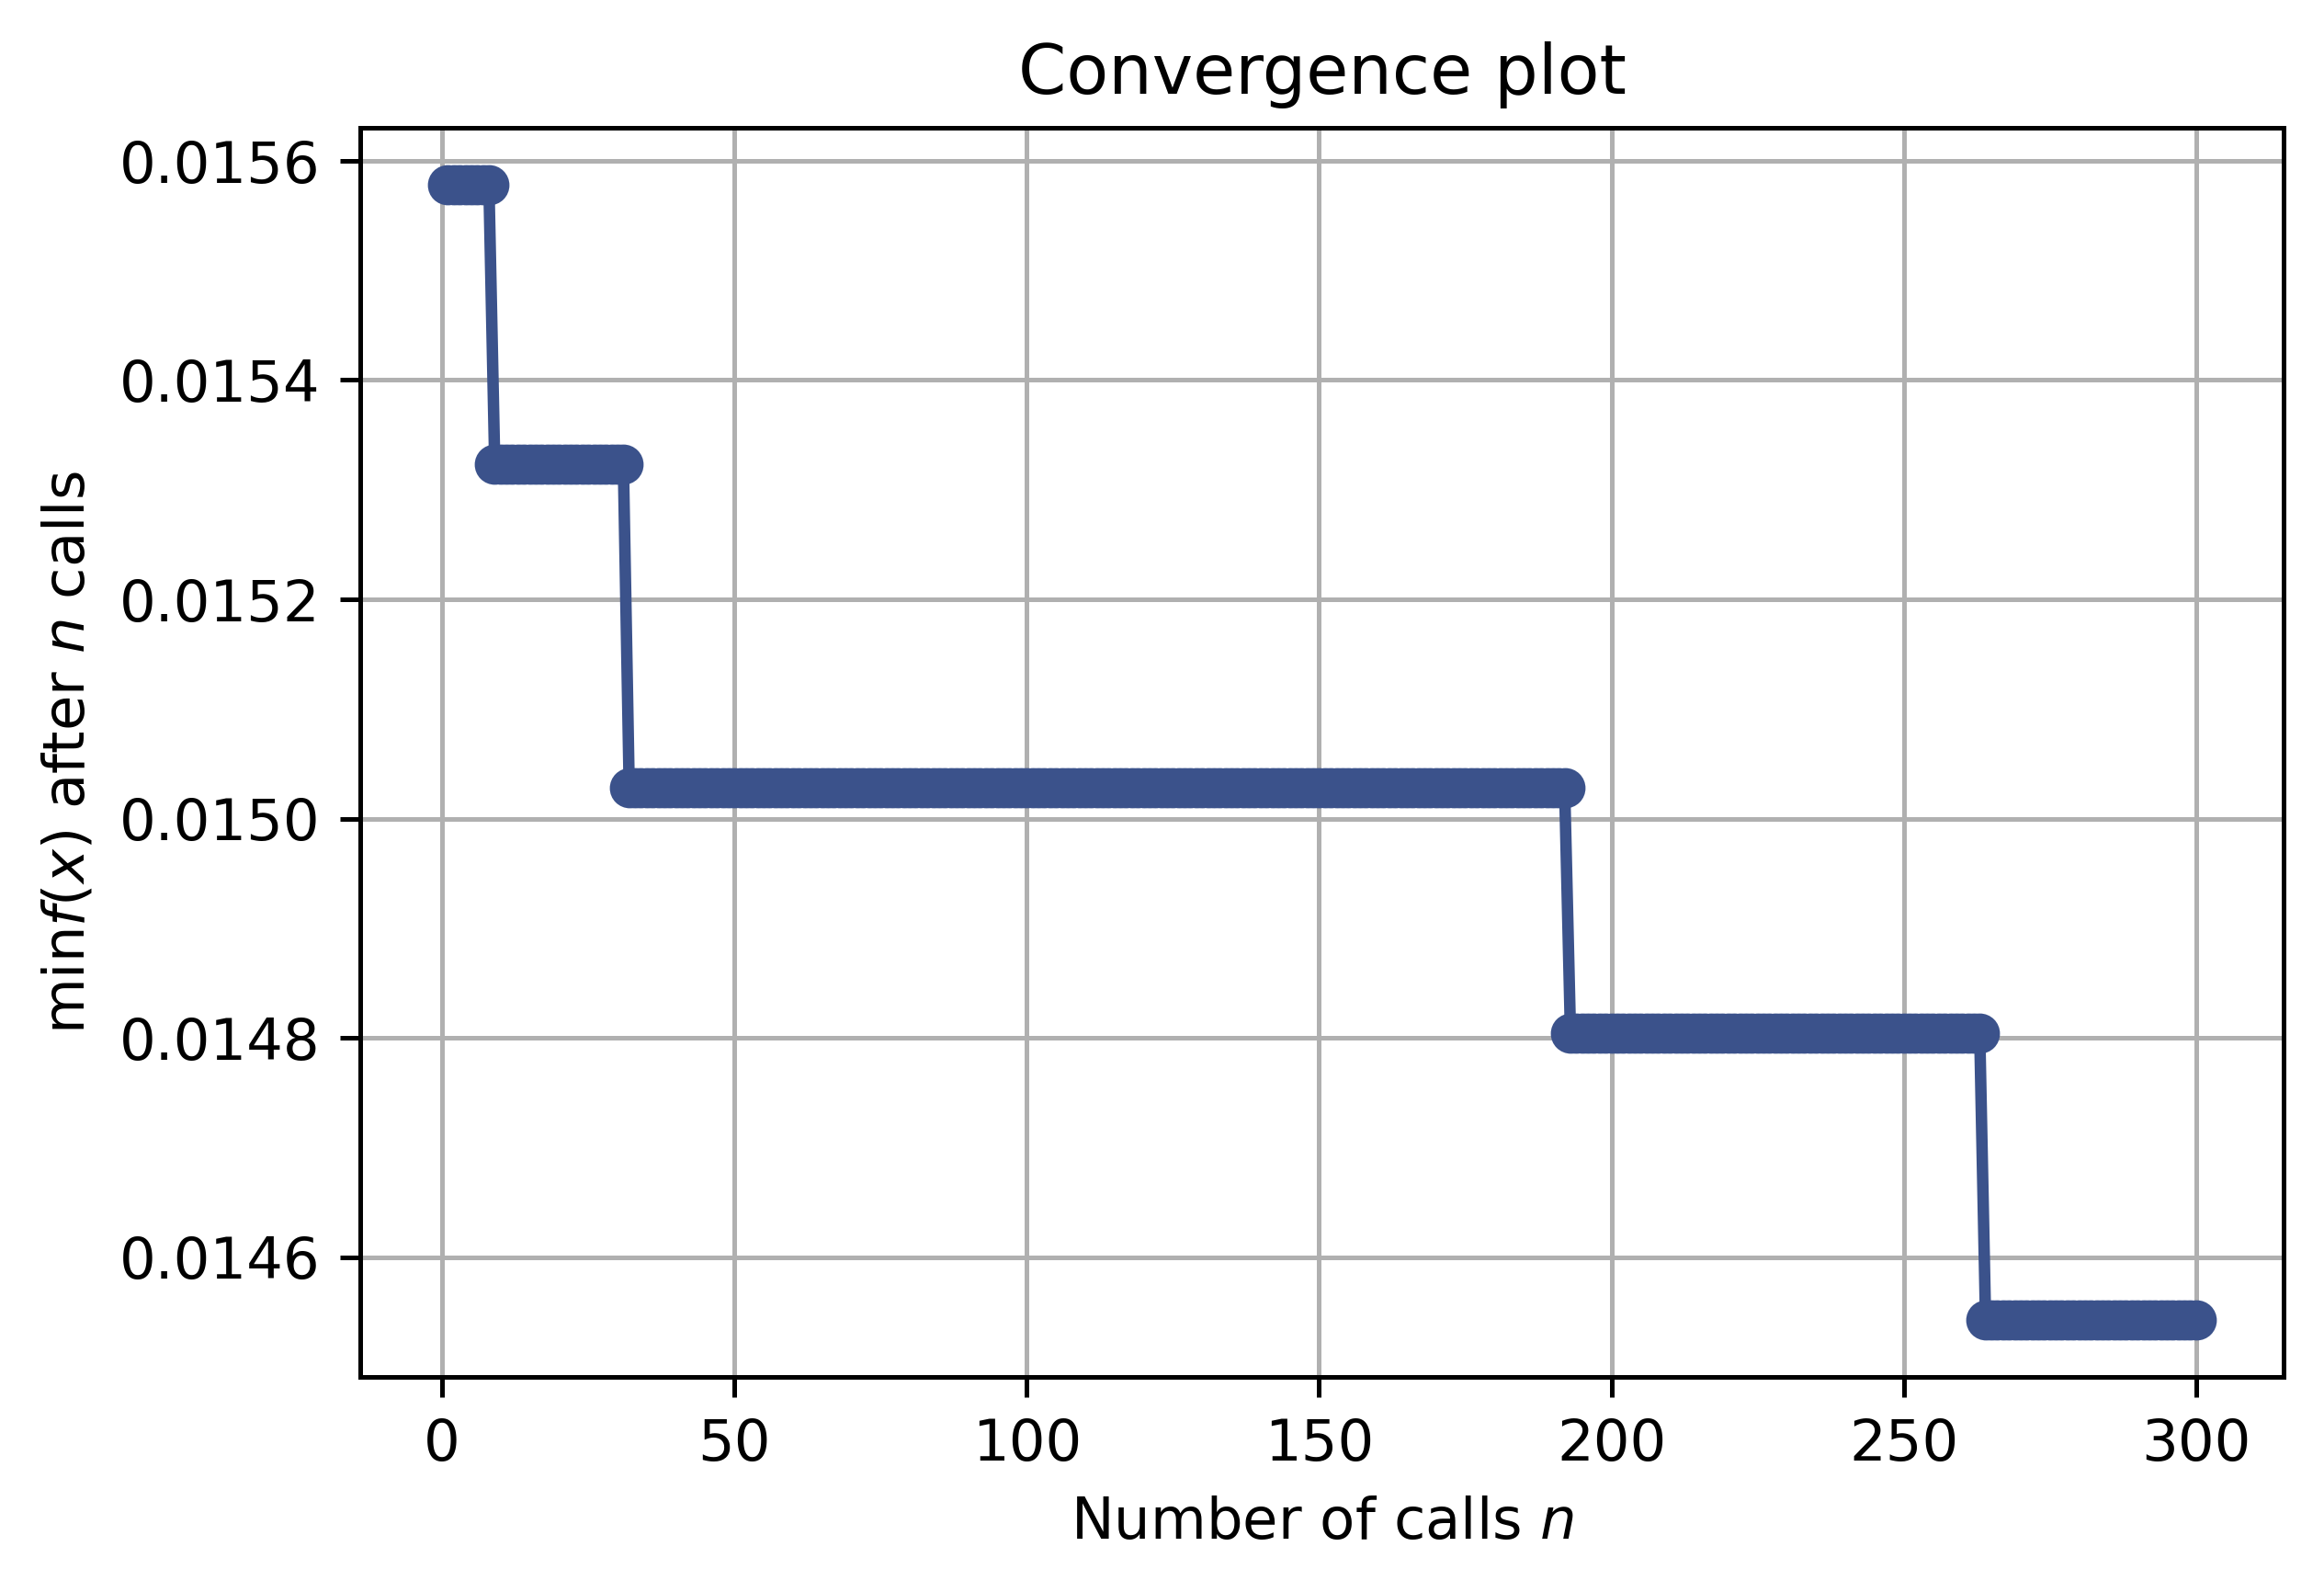

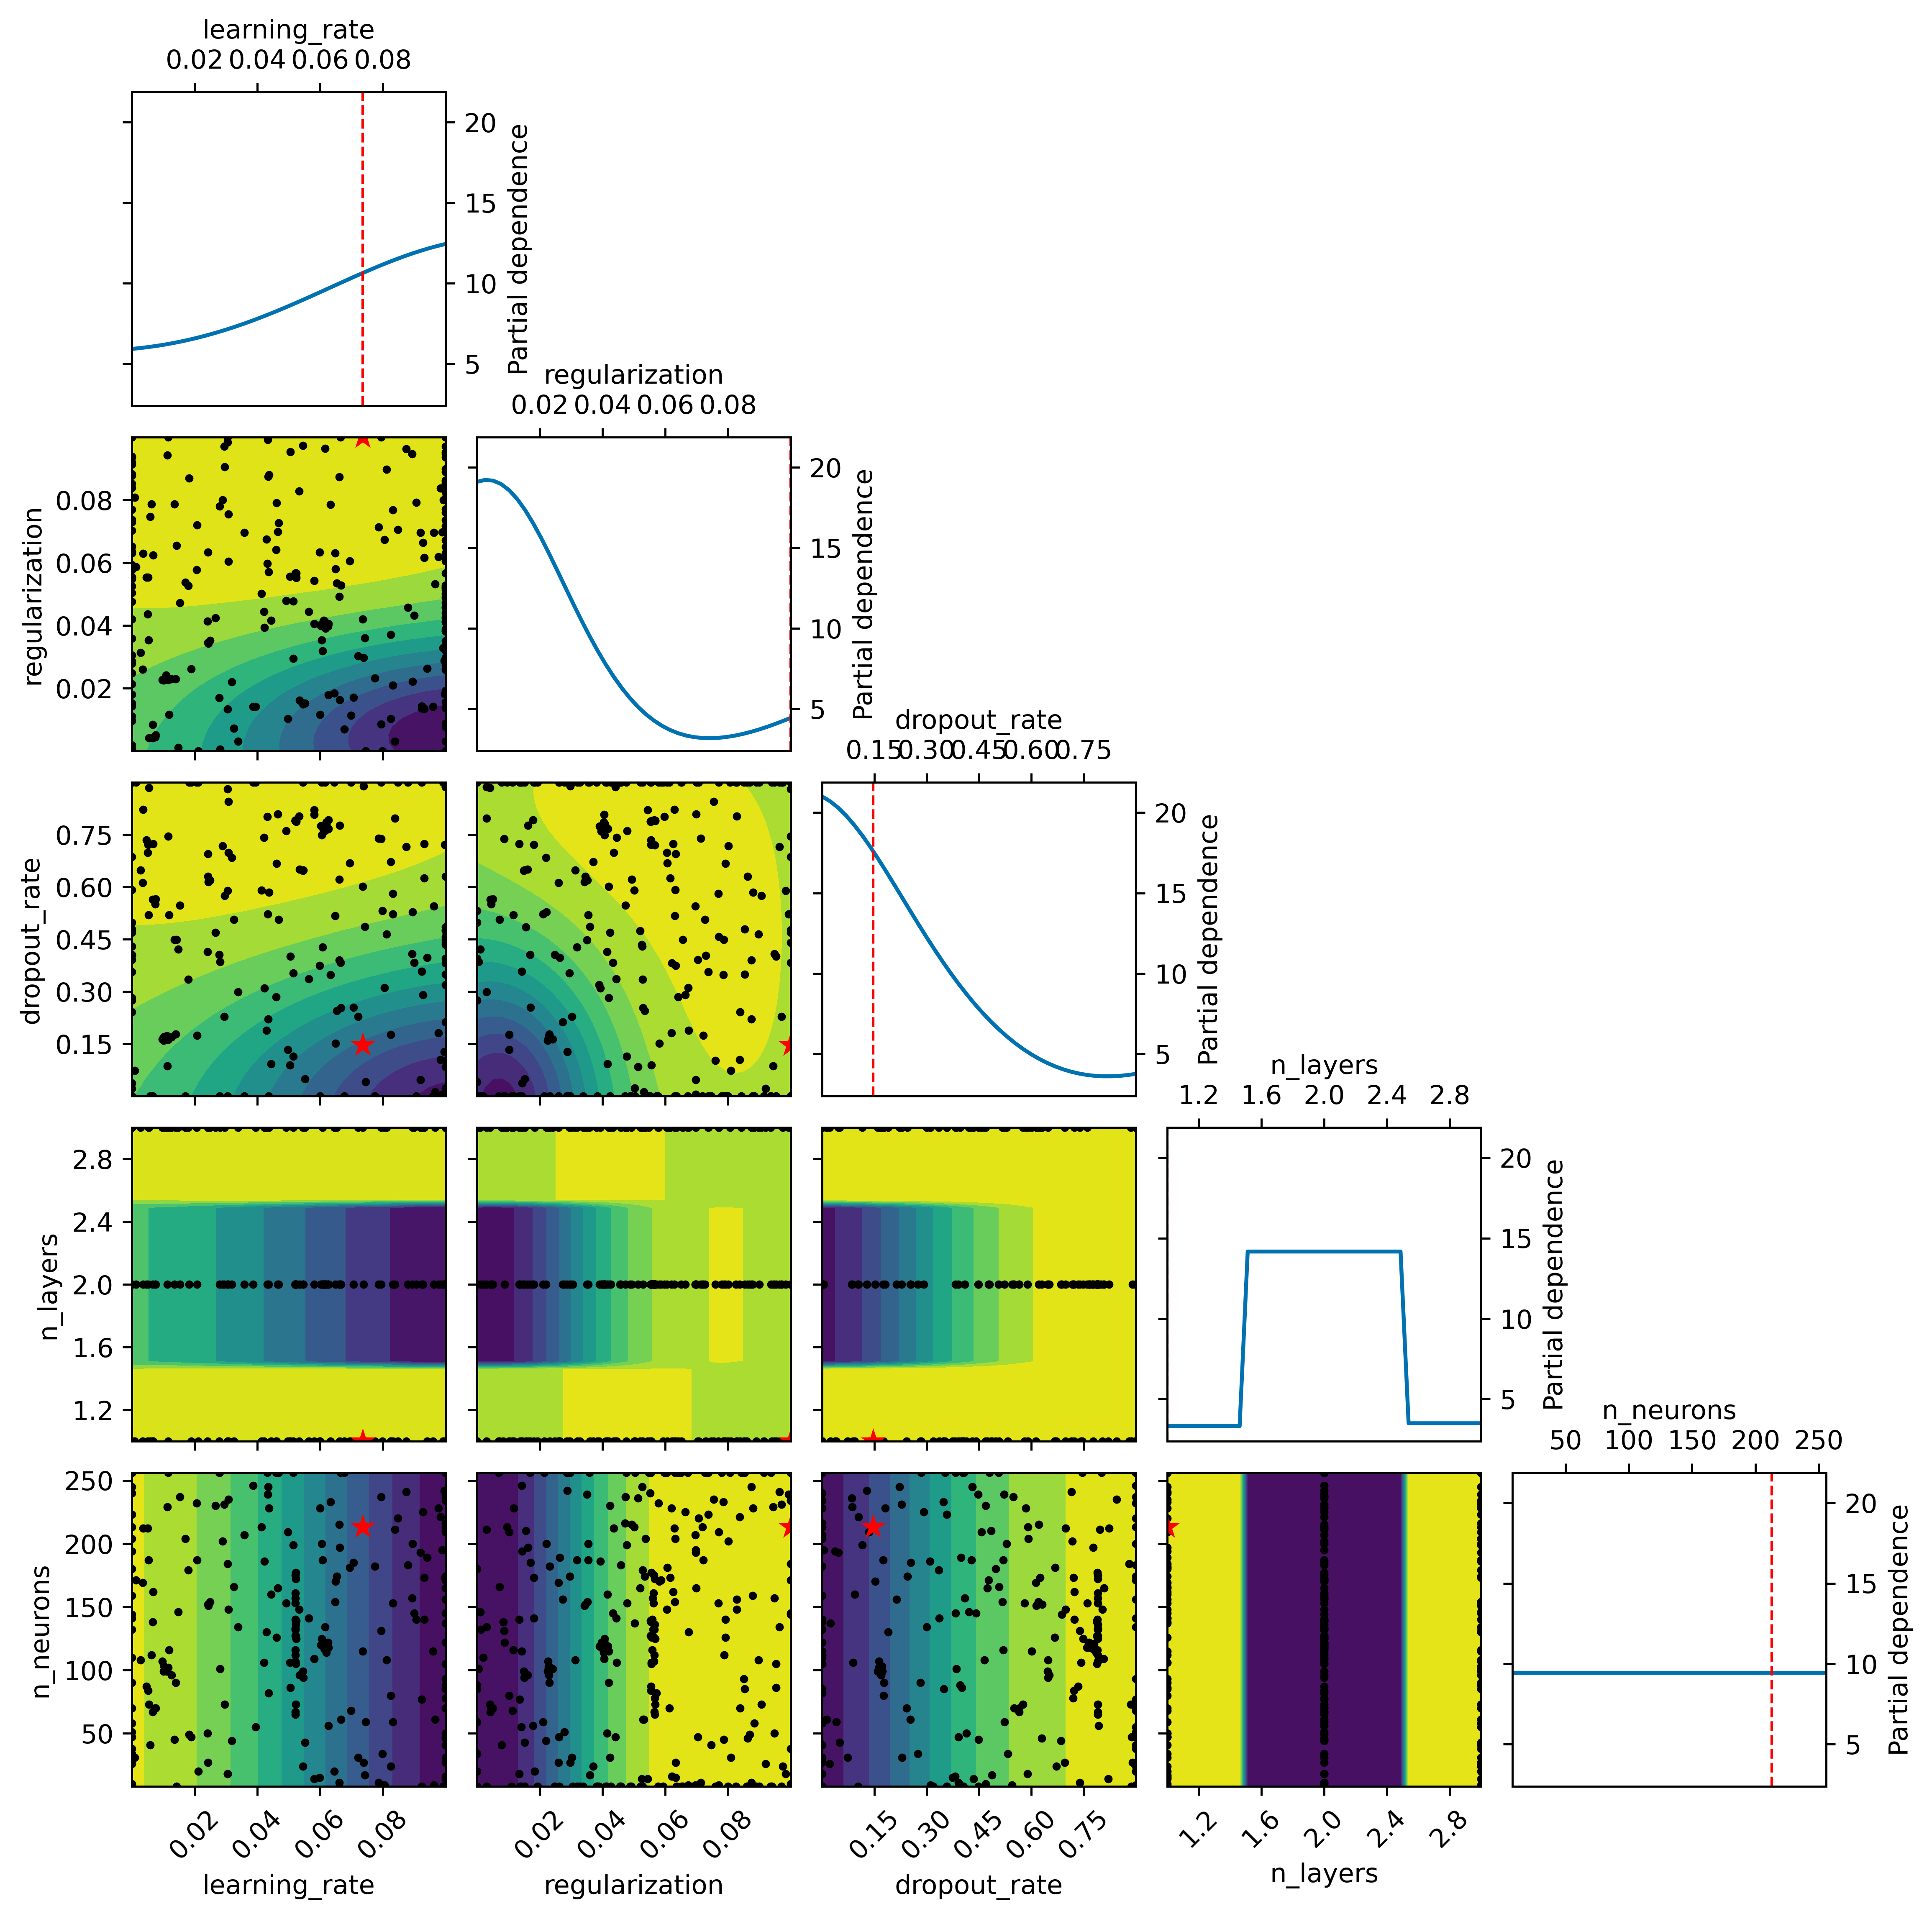

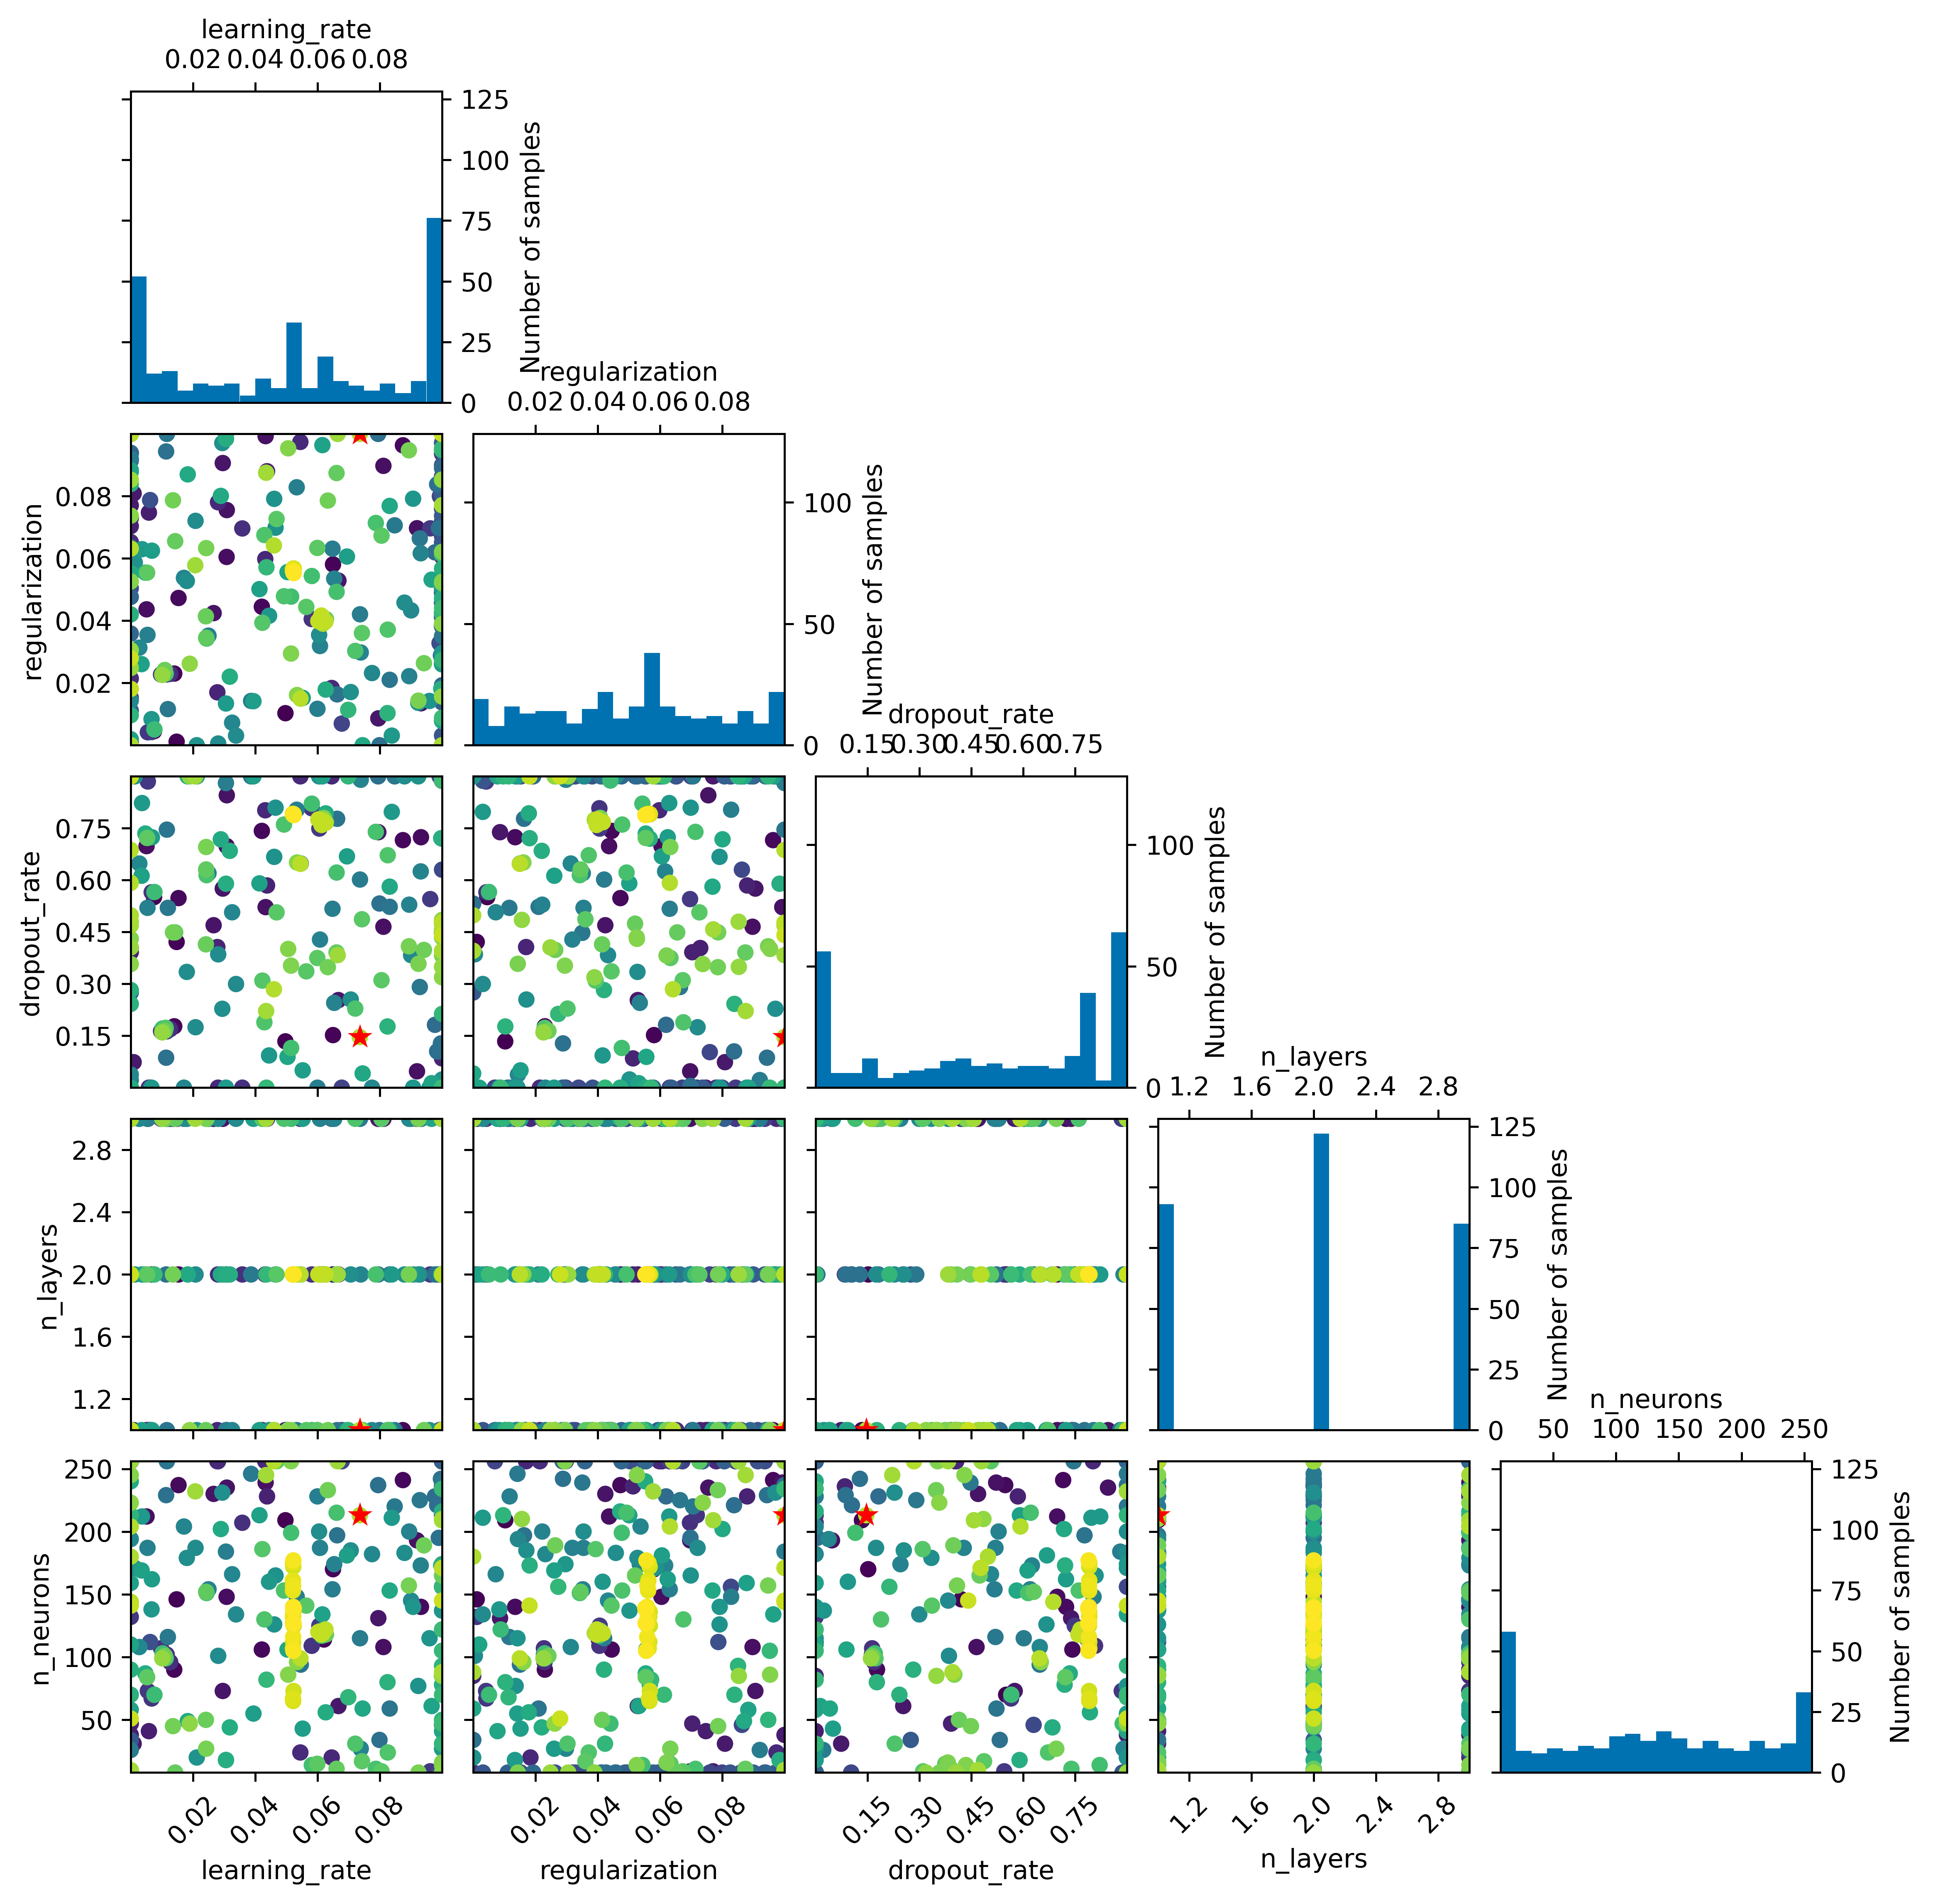

In [8]:
# ------------------- Bayesian optimization --------------------------------- #


class tqdm_skopt(object):
    """Progress bar object for functions with callbacks."""

    def __init__(self, **kwargs):
        self._bar = tqdm(**kwargs)

    def __call__(self, res):
        """Update bar with intermediate results."""
        self._bar.update()


# Set parameter search space
space = []
# space.append(Categorical(['relu', 'leakyrelu', 'elu'], name='activation'))
space.append(Real(1e-5, 1e-1, name='learning_rate'))
space.append(Real(1e-10, 1e-1, name='regularization'))
space.append(Real(0.0, 0.9, name='dropout_rate'))
# space.append(Integer(int(16), int(312), name='batch_size', dtype=int))
# space.append(Categorical(['relu', 'leakyrelu', 'prelu', 'elu', 'selu'], name='activation'))
space.append(Integer(int(1), int(3), name='n_layers', dtype=int))
space.append(Integer(int(8), int(256), name='n_neurons', dtype=int))

# Set default hyperparameters
default_params = [1e-3,
                  1e-5,
                  0.25,
                  2,
                  128]

# Work in progress
@use_named_args(dimensions=space)
def fitness(learning_rate, regularization, dropout_rate,
            n_layers, n_neurons):
    """Perform Bayesian Hyperparameter tuning."""

    # if activation == 'relu':
    #     activation = nn.ReLU()
    # elif activation == 'leakyrelu':
    #     activation = nn.LeakyReLU()
    # elif activation == 'elu':
    #     activation = nn.ELU()
    # elif activation == 'selu':
    #     activation = nn.SELU()
    # elif activation == 'prelu':
    #     activation = nn.PReLU()

    # print(f'Learning Rate: {learning_rate:.0e}, Regularization: {regularization:.0e}, ', end='')
    # print(f'Dropout: {dropout:.2f}')  #, Batch Size: {batch_size}')

    model = NeuralNet(activation=nn.ELU(), dropout_rate=dropout_rate,
                      n_layers=n_layers, n_neurons=n_neurons)
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                                                weight_decay=regularization)
    # Create k-fold cross validation
    avg_best_loss, *_ = kfold_cv_train(x_train=x_train, y_train=y_train,
                                     model=model, optimizer=optimizer,
                                     batch_size=312, patience=100)
    # print(f'Avg. best validation loss: {avg_best_loss}')

    return avg_best_loss

n_calls = 300
# Hyperparemeter search using Gaussian process minimization
gp_result = gp_minimize(func=fitness,
                        dimensions=space,
                        n_calls=n_calls,
                        n_initial_points=20,
                        random_state=SEED,
                        verbose=True, callback=[tqdm_skopt(total=n_calls,
                                          desc='Gaussian Process')])

plot_convergence(gp_result)
plot_objective(gp_result)
plot_evaluations(gp_result)
gp_result.x